##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">[weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 0s 0us/step


In [4]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [7]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7395c1ae10>],
      dtype=object)

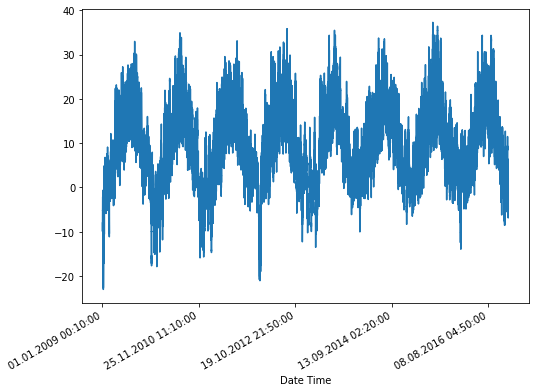

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [13]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/kbuilder/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

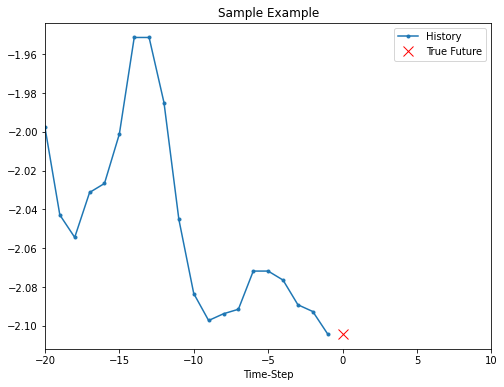

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [19]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/kbuilder/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

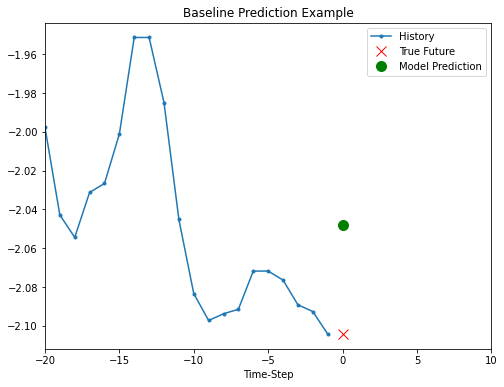

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10


  1/200 [..............................] - ETA: 3:34 - loss: 1.0850

 15/200 [=>............................] - ETA: 13s - loss: 0.9427 

 30/200 [===>..........................] - ETA: 6s - loss: 0.7959 

 45/200 [=====>........................] - ETA: 4s - loss: 0.6958

 60/200 [========>.....................] - ETA: 2s - loss: 0.6271

 74/200 [==========>...................] - ETA: 2s - loss: 0.5842

 88/200 [============>.................] - ETA: 1s - loss: 0.5549

103/200 [==============>...............] - ETA: 1s - loss: 0.5315

118/200 [================>.............] - ETA: 1s - loss: 0.5046

133/200 [==================>...........] - ETA: 0s - loss: 0.4739

149/200 [=====================>........] - ETA: 0s - loss: 0.4418

165/200 [=======================>......] - ETA: 0s - loss: 0.4175

180/200 [==========================>...] - ETA: 0s - loss: 0.4111

195/200 [============================>.] - ETA: 0s - loss: 0.4096

200/200 [==============================] - 2s 11ms/step - loss: 0.4075 - val_loss: 0.1351


Epoch 2/10
  1/200 [..............................] - ETA: 0s - loss: 0.2923

 16/200 [=>............................] - ETA: 0s - loss: 0.2451

 31/200 [===>..........................] - ETA: 0s - loss: 0.1949

 46/200 [=====>........................] - ETA: 0s - loss: 0.1645

 60/200 [========>.....................] - ETA: 0s - loss: 0.1488

 74/200 [==========>...................] - ETA: 0s - loss: 0.1457

 89/200 [============>.................] - ETA: 0s - loss: 0.1515

104/200 [==============>...............] - ETA: 0s - loss: 0.1491

119/200 [================>.............] - ETA: 0s - loss: 0.1428

134/200 [===================>..........] - ETA: 0s - loss: 0.1349

149/200 [=====================>........] - ETA: 0s - loss: 0.1272

164/200 [=======================>......] - ETA: 0s - loss: 0.1214

179/200 [=========================>....] - ETA: 0s - loss: 0.1177

193/200 [===========================>..] - ETA: 0s - loss: 0.1140

200/200 [==============================] - 1s 4ms/step - loss: 0.1118 - val_loss: 0.0360


Epoch 3/10
  1/200 [..............................] - ETA: 0s - loss: 0.0513

 16/200 [=>............................] - ETA: 0s - loss: 0.0512

 31/200 [===>..........................] - ETA: 0s - loss: 0.0485

 47/200 [======>.......................] - ETA: 0s - loss: 0.0474

 63/200 [========>.....................] - ETA: 0s - loss: 0.0488

 78/200 [==========>...................] - ETA: 0s - loss: 0.0501

 93/200 [============>.................] - ETA: 0s - loss: 0.0510

108/200 [===============>..............] - ETA: 0s - loss: 0.0518

123/200 [=================>............] - ETA: 0s - loss: 0.0525

138/200 [===================>..........] - ETA: 0s - loss: 0.0525

153/200 [=====================>........] - ETA: 0s - loss: 0.0519

168/200 [========================>.....] - ETA: 0s - loss: 0.0510

183/200 [==========================>...] - ETA: 0s - loss: 0.0499

198/200 [============================>.] - ETA: 0s - loss: 0.0488

200/200 [==============================] - 1s 4ms/step - loss: 0.0490 - val_loss: 0.0289


Epoch 4/10
  1/200 [..............................] - ETA: 0s - loss: 0.0645

 16/200 [=>............................] - ETA: 0s - loss: 0.0666

 31/200 [===>..........................] - ETA: 0s - loss: 0.0576

 46/200 [=====>........................] - ETA: 0s - loss: 0.0517

 61/200 [========>.....................] - ETA: 0s - loss: 0.0494

 76/200 [==========>...................] - ETA: 0s - loss: 0.0480

 91/200 [============>.................] - ETA: 0s - loss: 0.0477

106/200 [==============>...............] - ETA: 0s - loss: 0.0482

121/200 [=================>............] - ETA: 0s - loss: 0.0489

136/200 [===================>..........] - ETA: 0s - loss: 0.0488

151/200 [=====================>........] - ETA: 0s - loss: 0.0481

166/200 [=======================>......] - ETA: 0s - loss: 0.0472

181/200 [==========================>...] - ETA: 0s - loss: 0.0460

196/200 [============================>.] - ETA: 0s - loss: 0.0447

200/200 [==============================] - 1s 4ms/step - loss: 0.0444 - val_loss: 0.0257


Epoch 5/10
  1/200 [..............................] - ETA: 0s - loss: 0.0255

 16/200 [=>............................] - ETA: 0s - loss: 0.0253

 31/200 [===>..........................] - ETA: 0s - loss: 0.0243

 46/200 [=====>........................] - ETA: 0s - loss: 0.0239

 61/200 [========>.....................] - ETA: 0s - loss: 0.0242

 76/200 [==========>...................] - ETA: 0s - loss: 0.0248

 92/200 [============>.................] - ETA: 0s - loss: 0.0257

107/200 [===============>..............] - ETA: 0s - loss: 0.0271

122/200 [=================>............] - ETA: 0s - loss: 0.0289

137/200 [===================>..........] - ETA: 0s - loss: 0.0299

152/200 [=====================>........] - ETA: 0s - loss: 0.0303

166/200 [=======================>......] - ETA: 0s - loss: 0.0304

181/200 [==========================>...] - ETA: 0s - loss: 0.0302

196/200 [============================>.] - ETA: 0s - loss: 0.0300

200/200 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0235


Epoch 6/10
  1/200 [..............................] - ETA: 0s - loss: 0.0247

 16/200 [=>............................] - ETA: 0s - loss: 0.0254

 30/200 [===>..........................] - ETA: 0s - loss: 0.0261

 45/200 [=====>........................] - ETA: 0s - loss: 0.0265

 60/200 [========>.....................] - ETA: 0s - loss: 0.0271

 75/200 [==========>...................] - ETA: 0s - loss: 0.0277

 90/200 [============>.................] - ETA: 0s - loss: 0.0286

105/200 [==============>...............] - ETA: 0s - loss: 0.0297

120/200 [=================>............] - ETA: 0s - loss: 0.0304

135/200 [===================>..........] - ETA: 0s - loss: 0.0309

150/200 [=====================>........] - ETA: 0s - loss: 0.0311

165/200 [=======================>......] - ETA: 0s - loss: 0.0311

180/200 [==========================>...] - ETA: 0s - loss: 0.0316

195/200 [============================>.] - ETA: 0s - loss: 0.0317

200/200 [==============================] - 1s 4ms/step - loss: 0.0317 - val_loss: 0.0224


Epoch 7/10
  1/200 [..............................] - ETA: 0s - loss: 0.0317

 16/200 [=>............................] - ETA: 0s - loss: 0.0316

 31/200 [===>..........................] - ETA: 0s - loss: 0.0317

 46/200 [=====>........................] - ETA: 0s - loss: 0.0322

 61/200 [========>.....................] - ETA: 0s - loss: 0.0323

 76/200 [==========>...................] - ETA: 0s - loss: 0.0327

 91/200 [============>.................] - ETA: 0s - loss: 0.0324

106/200 [==============>...............] - ETA: 0s - loss: 0.0321

121/200 [=================>............] - ETA: 0s - loss: 0.0315

136/200 [===================>..........] - ETA: 0s - loss: 0.0309

151/200 [=====================>........] - ETA: 0s - loss: 0.0304

166/200 [=======================>......] - ETA: 0s - loss: 0.0297

181/200 [==========================>...] - ETA: 0s - loss: 0.0291

196/200 [============================>.] - ETA: 0s - loss: 0.0288

200/200 [==============================] - 1s 4ms/step - loss: 0.0287 - val_loss: 0.0206


Epoch 8/10
  1/200 [..............................] - ETA: 0s - loss: 0.0229

 16/200 [=>............................] - ETA: 0s - loss: 0.0262

 31/200 [===>..........................] - ETA: 0s - loss: 0.0265

 47/200 [======>.......................] - ETA: 0s - loss: 0.0273

 62/200 [========>.....................] - ETA: 0s - loss: 0.0291

 77/200 [==========>...................] - ETA: 0s - loss: 0.0298

 92/200 [============>.................] - ETA: 0s - loss: 0.0301

108/200 [===============>..............] - ETA: 0s - loss: 0.0298

124/200 [=================>............] - ETA: 0s - loss: 0.0293

139/200 [===================>..........] - ETA: 0s - loss: 0.0286

154/200 [======================>.......] - ETA: 0s - loss: 0.0280

169/200 [========================>.....] - ETA: 0s - loss: 0.0274

184/200 [==========================>...] - ETA: 0s - loss: 0.0268

199/200 [============================>.] - ETA: 0s - loss: 0.0264

200/200 [==============================] - 1s 4ms/step - loss: 0.0263 - val_loss: 0.0200


Epoch 9/10
  1/200 [..............................] - ETA: 0s - loss: 0.0245

 16/200 [=>............................] - ETA: 0s - loss: 0.0228

 32/200 [===>..........................] - ETA: 0s - loss: 0.0240

 47/200 [======>.......................] - ETA: 0s - loss: 0.0255

 62/200 [========>.....................] - ETA: 0s - loss: 0.0262

 77/200 [==========>...................] - ETA: 0s - loss: 0.0266

 92/200 [============>.................] - ETA: 0s - loss: 0.0268

108/200 [===============>..............] - ETA: 0s - loss: 0.0268

123/200 [=================>............] - ETA: 0s - loss: 0.0268

138/200 [===================>..........] - ETA: 0s - loss: 0.0266

153/200 [=====================>........] - ETA: 0s - loss: 0.0261

167/200 [========================>.....] - ETA: 0s - loss: 0.0257

182/200 [==========================>...] - ETA: 0s - loss: 0.0257

197/200 [============================>.] - ETA: 0s - loss: 0.0254

200/200 [==============================] - 1s 4ms/step - loss: 0.0254 - val_loss: 0.0182


Epoch 10/10
  1/200 [..............................] - ETA: 0s - loss: 0.0220

 16/200 [=>............................] - ETA: 0s - loss: 0.0221

 32/200 [===>..........................] - ETA: 0s - loss: 0.0227

 47/200 [======>.......................] - ETA: 0s - loss: 0.0230

 62/200 [========>.....................] - ETA: 0s - loss: 0.0238

 77/200 [==========>...................] - ETA: 0s - loss: 0.0244

 92/200 [============>.................] - ETA: 0s - loss: 0.0251

107/200 [===============>..............] - ETA: 0s - loss: 0.0254

122/200 [=================>............] - ETA: 0s - loss: 0.0254

137/200 [===================>..........] - ETA: 0s - loss: 0.0252

152/200 [=====================>........] - ETA: 0s - loss: 0.0247

167/200 [========================>.....] - ETA: 0s - loss: 0.0241

182/200 [==========================>...] - ETA: 0s - loss: 0.0235

197/200 [============================>.] - ETA: 0s - loss: 0.0229

200/200 [==============================] - 1s 4ms/step - loss: 0.0228 - val_loss: 0.0174


#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

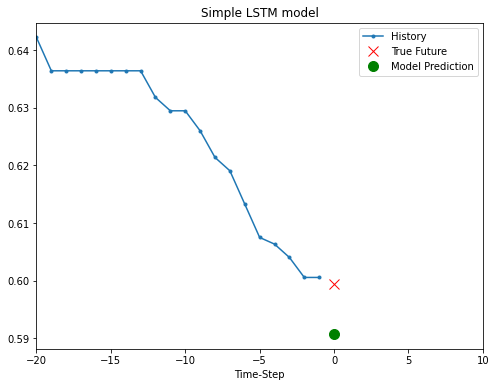

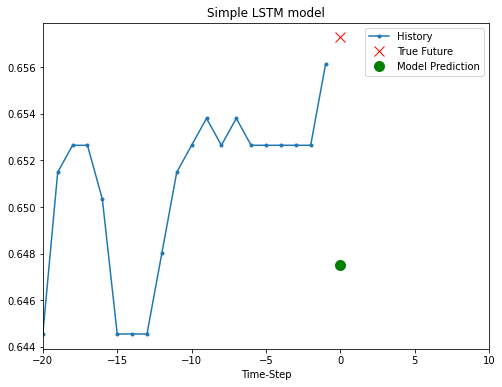

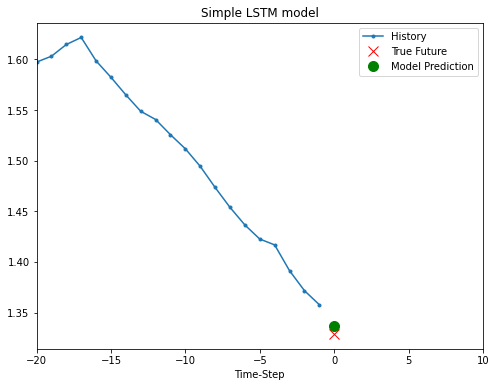

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f739544ef28>,
      dtype=object)

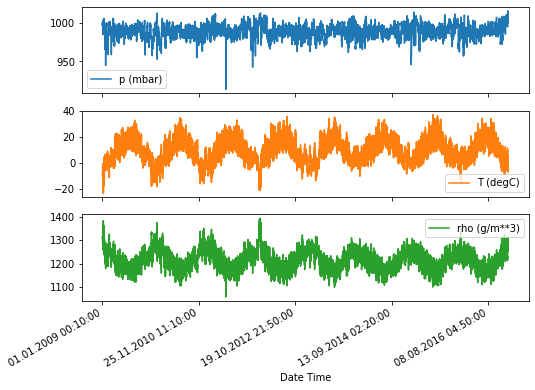

In [28]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10


  1/200 [..............................] - ETA: 5:35 - loss: 0.7783

  8/200 [>.............................] - ETA: 41s - loss: 0.4905 

 16/200 [=>............................] - ETA: 20s - loss: 0.4135

 23/200 [==>...........................] - ETA: 14s - loss: 0.4001

 30/200 [===>..........................] - ETA: 10s - loss: 0.3966

 38/200 [====>.........................] - ETA: 8s - loss: 0.3893 

 46/200 [=====>........................] - ETA: 6s - loss: 0.3863

 54/200 [=======>......................] - ETA: 5s - loss: 0.3816

 62/200 [========>.....................] - ETA: 4s - loss: 0.3753

 70/200 [=========>....................] - ETA: 4s - loss: 0.3716

 78/200 [==========>...................] - ETA: 3s - loss: 0.3667

 86/200 [===========>..................] - ETA: 3s - loss: 0.3603

 94/200 [=============>................] - ETA: 2s - loss: 0.3538

102/200 [==============>...............] - ETA: 2s - loss: 0.3474

110/200 [===============>..............] - ETA: 1s - loss: 0.3411

118/200 [================>.............] - ETA: 1s - loss: 0.3363

126/200 [=================>............] - ETA: 1s - loss: 0.3325

134/200 [===================>..........] - ETA: 1s - loss: 0.3289

142/200 [====================>.........] - ETA: 1s - loss: 0.3253

150/200 [=====================>........] - ETA: 0s - loss: 0.3215

158/200 [======================>.......] - ETA: 0s - loss: 0.3189

166/200 [=======================>......] - ETA: 0s - loss: 0.3170

174/200 [=========================>....] - ETA: 0s - loss: 0.3153

182/200 [==========================>...] - ETA: 0s - loss: 0.3132

190/200 [===========================>..] - ETA: 0s - loss: 0.3111

198/200 [============================>.] - ETA: 0s - loss: 0.3092

200/200 [==============================] - 4s 18ms/step - loss: 0.3090 - val_loss: 0.2646


Epoch 2/10
  1/200 [..............................] - ETA: 1s - loss: 0.2651

  9/200 [>.............................] - ETA: 1s - loss: 0.2697

 17/200 [=>............................] - ETA: 1s - loss: 0.2774

 25/200 [==>...........................] - ETA: 1s - loss: 0.2767

 33/200 [===>..........................] - ETA: 1s - loss: 0.2763

 41/200 [=====>........................] - ETA: 1s - loss: 0.2759

 49/200 [======>.......................] - ETA: 1s - loss: 0.2744

 57/200 [=======>......................] - ETA: 0s - loss: 0.2747

 65/200 [========>.....................] - ETA: 0s - loss: 0.2750

 73/200 [=========>....................] - ETA: 0s - loss: 0.2732

 81/200 [===========>..................] - ETA: 0s - loss: 0.2729

 89/200 [============>.................] - ETA: 0s - loss: 0.2718

 97/200 [=============>................] - ETA: 0s - loss: 0.2701

105/200 [==============>...............] - ETA: 0s - loss: 0.2688

113/200 [===============>..............] - ETA: 0s - loss: 0.2667

121/200 [=================>............] - ETA: 0s - loss: 0.2646

129/200 [==================>...........] - ETA: 0s - loss: 0.2630

137/200 [===================>..........] - ETA: 0s - loss: 0.2616

145/200 [====================>.........] - ETA: 0s - loss: 0.2611

153/200 [=====================>........] - ETA: 0s - loss: 0.2605

161/200 [=======================>......] - ETA: 0s - loss: 0.2599

169/200 [========================>.....] - ETA: 0s - loss: 0.2599

177/200 [=========================>....] - ETA: 0s - loss: 0.2610

185/200 [==========================>...] - ETA: 0s - loss: 0.2616

193/200 [===========================>..] - ETA: 0s - loss: 0.2620

200/200 [==============================] - 2s 9ms/step - loss: 0.2624 - val_loss: 0.2435


Epoch 3/10
  1/200 [..............................] - ETA: 1s - loss: 0.2630

  9/200 [>.............................] - ETA: 1s - loss: 0.2768

 17/200 [=>............................] - ETA: 1s - loss: 0.2706

 25/200 [==>...........................] - ETA: 1s - loss: 0.2698

 33/200 [===>..........................] - ETA: 1s - loss: 0.2720

 41/200 [=====>........................] - ETA: 1s - loss: 0.2726

 49/200 [======>.......................] - ETA: 1s - loss: 0.2709

 57/200 [=======>......................] - ETA: 0s - loss: 0.2678

 65/200 [========>.....................] - ETA: 0s - loss: 0.2683

 73/200 [=========>....................] - ETA: 0s - loss: 0.2680

 81/200 [===========>..................] - ETA: 0s - loss: 0.2671

 89/200 [============>.................] - ETA: 0s - loss: 0.2665

 97/200 [=============>................] - ETA: 0s - loss: 0.2655

105/200 [==============>...............] - ETA: 0s - loss: 0.2645

113/200 [===============>..............] - ETA: 0s - loss: 0.2635

121/200 [=================>............] - ETA: 0s - loss: 0.2630

129/200 [==================>...........] - ETA: 0s - loss: 0.2625

137/200 [===================>..........] - ETA: 0s - loss: 0.2627

145/200 [====================>.........] - ETA: 0s - loss: 0.2625

153/200 [=====================>........] - ETA: 0s - loss: 0.2626

161/200 [=======================>......] - ETA: 0s - loss: 0.2625

169/200 [========================>.....] - ETA: 0s - loss: 0.2624

177/200 [=========================>....] - ETA: 0s - loss: 0.2623

185/200 [==========================>...] - ETA: 0s - loss: 0.2620

193/200 [===========================>..] - ETA: 0s - loss: 0.2615

200/200 [==============================] - 2s 9ms/step - loss: 0.2616 - val_loss: 0.2472


Epoch 4/10
  1/200 [..............................] - ETA: 1s - loss: 0.2607

  9/200 [>.............................] - ETA: 1s - loss: 0.2611

 17/200 [=>............................] - ETA: 1s - loss: 0.2583

 25/200 [==>...........................] - ETA: 1s - loss: 0.2564

 33/200 [===>..........................] - ETA: 1s - loss: 0.2577

 41/200 [=====>........................] - ETA: 1s - loss: 0.2609

 49/200 [======>.......................] - ETA: 1s - loss: 0.2624

 57/200 [=======>......................] - ETA: 0s - loss: 0.2671

 65/200 [========>.....................] - ETA: 0s - loss: 0.2682

 73/200 [=========>....................] - ETA: 0s - loss: 0.2688

 81/200 [===========>..................] - ETA: 0s - loss: 0.2696

 89/200 [============>.................] - ETA: 0s - loss: 0.2685

 97/200 [=============>................] - ETA: 0s - loss: 0.2683

105/200 [==============>...............] - ETA: 0s - loss: 0.2664

113/200 [===============>..............] - ETA: 0s - loss: 0.2652

121/200 [=================>............] - ETA: 0s - loss: 0.2637

129/200 [==================>...........] - ETA: 0s - loss: 0.2630

137/200 [===================>..........] - ETA: 0s - loss: 0.2622

145/200 [====================>.........] - ETA: 0s - loss: 0.2617

153/200 [=====================>........] - ETA: 0s - loss: 0.2616

161/200 [=======================>......] - ETA: 0s - loss: 0.2612

169/200 [========================>.....] - ETA: 0s - loss: 0.2605

177/200 [=========================>....] - ETA: 0s - loss: 0.2594

185/200 [==========================>...] - ETA: 0s - loss: 0.2586

193/200 [===========================>..] - ETA: 0s - loss: 0.2575

200/200 [==============================] - 2s 9ms/step - loss: 0.2567 - val_loss: 0.2442


Epoch 5/10
  1/200 [..............................] - ETA: 1s - loss: 0.2353

  9/200 [>.............................] - ETA: 1s - loss: 0.2271

 17/200 [=>............................] - ETA: 1s - loss: 0.2167

 25/200 [==>...........................] - ETA: 1s - loss: 0.2167

 33/200 [===>..........................] - ETA: 1s - loss: 0.2161

 41/200 [=====>........................] - ETA: 1s - loss: 0.2137

 49/200 [======>.......................] - ETA: 1s - loss: 0.2151

 57/200 [=======>......................] - ETA: 0s - loss: 0.2166

 65/200 [========>.....................] - ETA: 0s - loss: 0.2175

 73/200 [=========>....................] - ETA: 0s - loss: 0.2170

 81/200 [===========>..................] - ETA: 0s - loss: 0.2189

 89/200 [============>.................] - ETA: 0s - loss: 0.2194

 97/200 [=============>................] - ETA: 0s - loss: 0.2186

105/200 [==============>...............] - ETA: 0s - loss: 0.2194

113/200 [===============>..............] - ETA: 0s - loss: 0.2203

121/200 [=================>............] - ETA: 0s - loss: 0.2207

129/200 [==================>...........] - ETA: 0s - loss: 0.2210

137/200 [===================>..........] - ETA: 0s - loss: 0.2208

145/200 [====================>.........] - ETA: 0s - loss: 0.2208

153/200 [=====================>........] - ETA: 0s - loss: 0.2215

161/200 [=======================>......] - ETA: 0s - loss: 0.2228

169/200 [========================>.....] - ETA: 0s - loss: 0.2242

177/200 [=========================>....] - ETA: 0s - loss: 0.2249

185/200 [==========================>...] - ETA: 0s - loss: 0.2255

193/200 [===========================>..] - ETA: 0s - loss: 0.2259

200/200 [==============================] - 2s 9ms/step - loss: 0.2263 - val_loss: 0.2346


Epoch 6/10
  1/200 [..............................] - ETA: 1s - loss: 0.2300

  9/200 [>.............................] - ETA: 1s - loss: 0.2469

 17/200 [=>............................] - ETA: 1s - loss: 0.2430

 25/200 [==>...........................] - ETA: 1s - loss: 0.2421

 33/200 [===>..........................] - ETA: 1s - loss: 0.2443

 41/200 [=====>........................] - ETA: 1s - loss: 0.2474

 49/200 [======>.......................] - ETA: 0s - loss: 0.2500

 57/200 [=======>......................] - ETA: 0s - loss: 0.2504

 65/200 [========>.....................] - ETA: 0s - loss: 0.2512

 73/200 [=========>....................] - ETA: 0s - loss: 0.2518

 81/200 [===========>..................] - ETA: 0s - loss: 0.2507

 89/200 [============>.................] - ETA: 0s - loss: 0.2501

 97/200 [=============>................] - ETA: 0s - loss: 0.2500

105/200 [==============>...............] - ETA: 0s - loss: 0.2498

113/200 [===============>..............] - ETA: 0s - loss: 0.2496

121/200 [=================>............] - ETA: 0s - loss: 0.2484

129/200 [==================>...........] - ETA: 0s - loss: 0.2475

137/200 [===================>..........] - ETA: 0s - loss: 0.2458

145/200 [====================>.........] - ETA: 0s - loss: 0.2441

153/200 [=====================>........] - ETA: 0s - loss: 0.2429

161/200 [=======================>......] - ETA: 0s - loss: 0.2415

169/200 [========================>.....] - ETA: 0s - loss: 0.2402

177/200 [=========================>....] - ETA: 0s - loss: 0.2405

185/200 [==========================>...] - ETA: 0s - loss: 0.2407

193/200 [===========================>..] - ETA: 0s - loss: 0.2413

200/200 [==============================] - 2s 9ms/step - loss: 0.2416 - val_loss: 0.2643


Epoch 7/10
  1/200 [..............................] - ETA: 1s - loss: 0.2428

  9/200 [>.............................] - ETA: 1s - loss: 0.2460

 17/200 [=>............................] - ETA: 1s - loss: 0.2469

 25/200 [==>...........................] - ETA: 1s - loss: 0.2495

 33/200 [===>..........................] - ETA: 1s - loss: 0.2496

 41/200 [=====>........................] - ETA: 1s - loss: 0.2497

 49/200 [======>.......................] - ETA: 0s - loss: 0.2476

 57/200 [=======>......................] - ETA: 0s - loss: 0.2451

 65/200 [========>.....................] - ETA: 0s - loss: 0.2442

 73/200 [=========>....................] - ETA: 0s - loss: 0.2425

 81/200 [===========>..................] - ETA: 0s - loss: 0.2414

 89/200 [============>.................] - ETA: 0s - loss: 0.2406

 97/200 [=============>................] - ETA: 0s - loss: 0.2402

105/200 [==============>...............] - ETA: 0s - loss: 0.2404

113/200 [===============>..............] - ETA: 0s - loss: 0.2396

121/200 [=================>............] - ETA: 0s - loss: 0.2386

129/200 [==================>...........] - ETA: 0s - loss: 0.2382

137/200 [===================>..........] - ETA: 0s - loss: 0.2384

145/200 [====================>.........] - ETA: 0s - loss: 0.2396

153/200 [=====================>........] - ETA: 0s - loss: 0.2401

161/200 [=======================>......] - ETA: 0s - loss: 0.2405

169/200 [========================>.....] - ETA: 0s - loss: 0.2401

177/200 [=========================>....] - ETA: 0s - loss: 0.2404

186/200 [==========================>...] - ETA: 0s - loss: 0.2409

194/200 [============================>.] - ETA: 0s - loss: 0.2409

200/200 [==============================] - 2s 9ms/step - loss: 0.2411 - val_loss: 0.2577


Epoch 8/10
  1/200 [..............................] - ETA: 1s - loss: 0.2697

  9/200 [>.............................] - ETA: 1s - loss: 0.2588

 17/200 [=>............................] - ETA: 1s - loss: 0.2542

 25/200 [==>...........................] - ETA: 1s - loss: 0.2550

 33/200 [===>..........................] - ETA: 1s - loss: 0.2541

 41/200 [=====>........................] - ETA: 1s - loss: 0.2498

 49/200 [======>.......................] - ETA: 1s - loss: 0.2487

 56/200 [=======>......................] - ETA: 0s - loss: 0.2479

 63/200 [========>.....................] - ETA: 0s - loss: 0.2469

 71/200 [=========>....................] - ETA: 0s - loss: 0.2432

 79/200 [==========>...................] - ETA: 0s - loss: 0.2421

 87/200 [============>.................] - ETA: 0s - loss: 0.2405

 94/200 [=============>................] - ETA: 0s - loss: 0.2385

102/200 [==============>...............] - ETA: 0s - loss: 0.2366

110/200 [===============>..............] - ETA: 0s - loss: 0.2359

118/200 [================>.............] - ETA: 0s - loss: 0.2366

126/200 [=================>............] - ETA: 0s - loss: 0.2364

134/200 [===================>..........] - ETA: 0s - loss: 0.2360

142/200 [====================>.........] - ETA: 0s - loss: 0.2366

150/200 [=====================>........] - ETA: 0s - loss: 0.2372

158/200 [======================>.......] - ETA: 0s - loss: 0.2378

166/200 [=======================>......] - ETA: 0s - loss: 0.2385

174/200 [=========================>....] - ETA: 0s - loss: 0.2394

182/200 [==========================>...] - ETA: 0s - loss: 0.2401

190/200 [===========================>..] - ETA: 0s - loss: 0.2404

198/200 [============================>.] - ETA: 0s - loss: 0.2409

200/200 [==============================] - 2s 9ms/step - loss: 0.2410 - val_loss: 0.2388


Epoch 9/10
  1/200 [..............................] - ETA: 1s - loss: 0.2677

  9/200 [>.............................] - ETA: 1s - loss: 0.2591

 17/200 [=>............................] - ETA: 1s - loss: 0.2525

 25/200 [==>...........................] - ETA: 1s - loss: 0.2514

 33/200 [===>..........................] - ETA: 1s - loss: 0.2531

 41/200 [=====>........................] - ETA: 1s - loss: 0.2525

 49/200 [======>.......................] - ETA: 1s - loss: 0.2519

 57/200 [=======>......................] - ETA: 0s - loss: 0.2498

 65/200 [========>.....................] - ETA: 0s - loss: 0.2482

 73/200 [=========>....................] - ETA: 0s - loss: 0.2476

 81/200 [===========>..................] - ETA: 0s - loss: 0.2472

 89/200 [============>.................] - ETA: 0s - loss: 0.2477

 97/200 [=============>................] - ETA: 0s - loss: 0.2467

105/200 [==============>...............] - ETA: 0s - loss: 0.2466

113/200 [===============>..............] - ETA: 0s - loss: 0.2476

121/200 [=================>............] - ETA: 0s - loss: 0.2470

129/200 [==================>...........] - ETA: 0s - loss: 0.2464

137/200 [===================>..........] - ETA: 0s - loss: 0.2468

145/200 [====================>.........] - ETA: 0s - loss: 0.2468

153/200 [=====================>........] - ETA: 0s - loss: 0.2469

161/200 [=======================>......] - ETA: 0s - loss: 0.2463

169/200 [========================>.....] - ETA: 0s - loss: 0.2461

177/200 [=========================>....] - ETA: 0s - loss: 0.2458

185/200 [==========================>...] - ETA: 0s - loss: 0.2454

193/200 [===========================>..] - ETA: 0s - loss: 0.2450

200/200 [==============================] - 2s 9ms/step - loss: 0.2447 - val_loss: 0.2485


Epoch 10/10
  1/200 [..............................] - ETA: 1s - loss: 0.2300

  8/200 [>.............................] - ETA: 1s - loss: 0.2536

 15/200 [=>............................] - ETA: 1s - loss: 0.2551

 23/200 [==>...........................] - ETA: 1s - loss: 0.2570

 31/200 [===>..........................] - ETA: 1s - loss: 0.2601

 38/200 [====>.........................] - ETA: 1s - loss: 0.2600

 45/200 [=====>........................] - ETA: 1s - loss: 0.2603

 53/200 [======>.......................] - ETA: 1s - loss: 0.2609

 60/200 [========>.....................] - ETA: 1s - loss: 0.2588

 67/200 [=========>....................] - ETA: 0s - loss: 0.2572

 74/200 [==========>...................] - ETA: 0s - loss: 0.2555

 82/200 [===========>..................] - ETA: 0s - loss: 0.2536

 90/200 [============>.................] - ETA: 0s - loss: 0.2516

 98/200 [=============>................] - ETA: 0s - loss: 0.2501

106/200 [==============>...............] - ETA: 0s - loss: 0.2488

114/200 [================>.............] - ETA: 0s - loss: 0.2485

122/200 [=================>............] - ETA: 0s - loss: 0.2481

130/200 [==================>...........] - ETA: 0s - loss: 0.2482

138/200 [===================>..........] - ETA: 0s - loss: 0.2479

146/200 [====================>.........] - ETA: 0s - loss: 0.2467

154/200 [======================>.......] - ETA: 0s - loss: 0.2462

162/200 [=======================>......] - ETA: 0s - loss: 0.2451

170/200 [========================>.....] - ETA: 0s - loss: 0.2440

178/200 [=========================>....] - ETA: 0s - loss: 0.2425

186/200 [==========================>...] - ETA: 0s - loss: 0.2409

194/200 [============================>.] - ETA: 0s - loss: 0.2397

200/200 [==============================] - 2s 9ms/step - loss: 0.2388 - val_loss: 0.2422


In [38]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

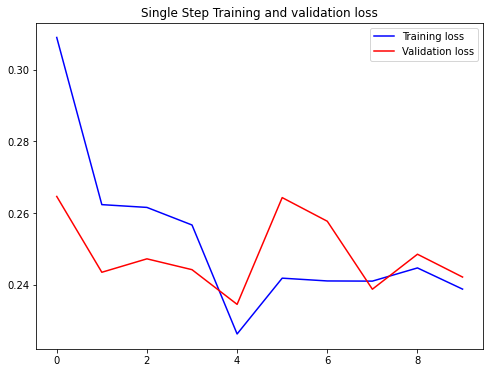

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

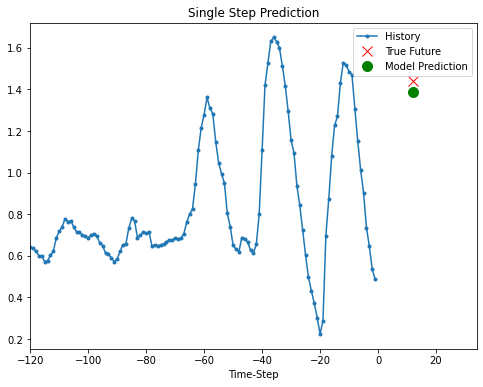

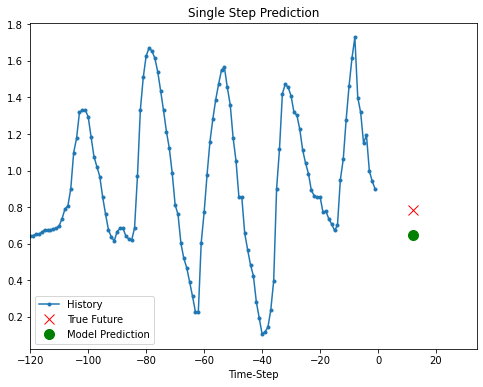

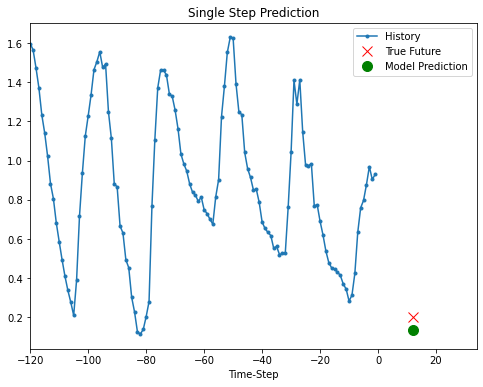

In [40]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [41]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [43]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [44]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

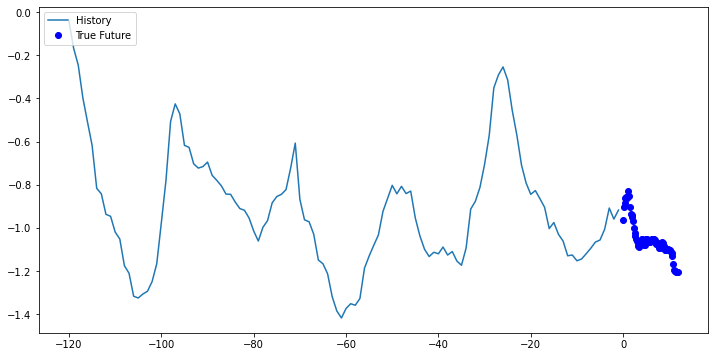

In [45]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [46]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [47]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [48]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10


  1/200 [..............................] - ETA: 8:24 - loss: 1.1390

  2/200 [..............................] - ETA: 4:18 - loss: 1.1100

  3/200 [..............................] - ETA: 2:58 - loss: 1.0828

  4/200 [..............................] - ETA: 2:17 - loss: 1.0768

  5/200 [..............................] - ETA: 1:52 - loss: 1.0582

  6/200 [..............................] - ETA: 1:35 - loss: 1.0338

  7/200 [>.............................] - ETA: 1:23 - loss: 1.0154

  8/200 [>.............................] - ETA: 1:14 - loss: 0.9967

  9/200 [>.............................] - ETA: 1:07 - loss: 0.9823

 10/200 [>.............................] - ETA: 1:02 - loss: 0.9676

 11/200 [>.............................] - ETA: 58s - loss: 0.9570 

 12/200 [>.............................] - ETA: 54s - loss: 0.9441

 13/200 [>.............................] - ETA: 50s - loss: 0.9292

 14/200 [=>............................] - ETA: 48s - loss: 0.9148

 15/200 [=>............................] - ETA: 45s - loss: 0.9106

 16/200 [=>............................] - ETA: 43s - loss: 0.9001

 17/200 [=>............................] - ETA: 41s - loss: 0.8900

 18/200 [=>............................] - ETA: 40s - loss: 0.8805

 19/200 [=>............................] - ETA: 38s - loss: 0.8694

 20/200 [==>...........................] - ETA: 37s - loss: 0.8586

 21/200 [==>...........................] - ETA: 35s - loss: 0.8488

 22/200 [==>...........................] - ETA: 34s - loss: 0.8399

 23/200 [==>...........................] - ETA: 33s - loss: 0.8310

 24/200 [==>...........................] - ETA: 32s - loss: 0.8225

 25/200 [==>...........................] - ETA: 31s - loss: 0.8143

 26/200 [==>...........................] - ETA: 31s - loss: 0.8057

 27/200 [===>..........................] - ETA: 30s - loss: 0.7974

 28/200 [===>..........................] - ETA: 29s - loss: 0.7891

 29/200 [===>..........................] - ETA: 28s - loss: 0.7816

 30/200 [===>..........................] - ETA: 28s - loss: 0.7733

 31/200 [===>..........................] - ETA: 27s - loss: 0.7662

 32/200 [===>..........................] - ETA: 27s - loss: 0.7586

 33/200 [===>..........................] - ETA: 26s - loss: 0.7514

 34/200 [====>.........................] - ETA: 25s - loss: 0.7449

 35/200 [====>.........................] - ETA: 25s - loss: 0.7377

 36/200 [====>.........................] - ETA: 24s - loss: 0.7318

 37/200 [====>.........................] - ETA: 24s - loss: 0.7256

 38/200 [====>.........................] - ETA: 24s - loss: 0.7206

 39/200 [====>.........................] - ETA: 23s - loss: 0.7160

 40/200 [=====>........................] - ETA: 23s - loss: 0.7109

 41/200 [=====>........................] - ETA: 22s - loss: 0.7066

 42/200 [=====>........................] - ETA: 22s - loss: 0.7025

 43/200 [=====>........................] - ETA: 22s - loss: 0.6985

 44/200 [=====>........................] - ETA: 21s - loss: 0.6948

 45/200 [=====>........................] - ETA: 21s - loss: 0.6912

 46/200 [=====>........................] - ETA: 21s - loss: 0.6869

 47/200 [======>.......................] - ETA: 20s - loss: 0.6828

 48/200 [======>.......................] - ETA: 20s - loss: 0.6792

 49/200 [======>.......................] - ETA: 20s - loss: 0.6757

 50/200 [======>.......................] - ETA: 19s - loss: 0.6720

 51/200 [======>.......................] - ETA: 19s - loss: 0.6684

 52/200 [======>.......................] - ETA: 19s - loss: 0.6654

 53/200 [======>.......................] - ETA: 19s - loss: 0.6629

 54/200 [=======>......................] - ETA: 18s - loss: 0.6600

 55/200 [=======>......................] - ETA: 18s - loss: 0.6569

 56/200 [=======>......................] - ETA: 18s - loss: 0.6541

 57/200 [=======>......................] - ETA: 18s - loss: 0.6513

 58/200 [=======>......................] - ETA: 17s - loss: 0.6486

 59/200 [=======>......................] - ETA: 17s - loss: 0.6462

 60/200 [========>.....................] - ETA: 17s - loss: 0.6437

 61/200 [========>.....................] - ETA: 17s - loss: 0.6413

 62/200 [========>.....................] - ETA: 17s - loss: 0.6393

 63/200 [========>.....................] - ETA: 16s - loss: 0.6373

 64/200 [========>.....................] - ETA: 16s - loss: 0.6359

 65/200 [========>.....................] - ETA: 16s - loss: 0.6350

 66/200 [========>.....................] - ETA: 16s - loss: 0.6333

 67/200 [=========>....................] - ETA: 16s - loss: 0.6314

 68/200 [=========>....................] - ETA: 15s - loss: 0.6299

 69/200 [=========>....................] - ETA: 15s - loss: 0.6281

 70/200 [=========>....................] - ETA: 15s - loss: 0.6269

 71/200 [=========>....................] - ETA: 15s - loss: 0.6254

 72/200 [=========>....................] - ETA: 15s - loss: 0.6236

 73/200 [=========>....................] - ETA: 14s - loss: 0.6225

 74/200 [==========>...................] - ETA: 14s - loss: 0.6219

 75/200 [==========>...................] - ETA: 14s - loss: 0.6209

 76/200 [==========>...................] - ETA: 14s - loss: 0.6199

 77/200 [==========>...................] - ETA: 14s - loss: 0.6190

 78/200 [==========>...................] - ETA: 14s - loss: 0.6181

 79/200 [==========>...................] - ETA: 13s - loss: 0.6173

 80/200 [===========>..................] - ETA: 13s - loss: 0.6166

 81/200 [===========>..................] - ETA: 13s - loss: 0.6160

 82/200 [===========>..................] - ETA: 13s - loss: 0.6149

 83/200 [===========>..................] - ETA: 13s - loss: 0.6143

 84/200 [===========>..................] - ETA: 13s - loss: 0.6138

 85/200 [===========>..................] - ETA: 12s - loss: 0.6132

 86/200 [===========>..................] - ETA: 12s - loss: 0.6126

 87/200 [============>.................] - ETA: 12s - loss: 0.6121

 88/200 [============>.................] - ETA: 12s - loss: 0.6117

 89/200 [============>.................] - ETA: 12s - loss: 0.6114

 90/200 [============>.................] - ETA: 12s - loss: 0.6111

 91/200 [============>.................] - ETA: 12s - loss: 0.6111

 92/200 [============>.................] - ETA: 11s - loss: 0.6111

 93/200 [============>.................] - ETA: 11s - loss: 0.6107

 94/200 [=============>................] - ETA: 11s - loss: 0.6103

 95/200 [=============>................] - ETA: 11s - loss: 0.6101

 96/200 [=============>................] - ETA: 11s - loss: 0.6101

 97/200 [=============>................] - ETA: 11s - loss: 0.6100

 98/200 [=============>................] - ETA: 11s - loss: 0.6097

 99/200 [=============>................] - ETA: 10s - loss: 0.6092

100/200 [==============>...............] - ETA: 10s - loss: 0.6087

101/200 [==============>...............] - ETA: 10s - loss: 0.6082

102/200 [==============>...............] - ETA: 10s - loss: 0.6078

103/200 [==============>...............] - ETA: 10s - loss: 0.6072

104/200 [==============>...............] - ETA: 10s - loss: 0.6065

105/200 [==============>...............] - ETA: 10s - loss: 0.6060

106/200 [==============>...............] - ETA: 10s - loss: 0.6053

107/200 [===============>..............] - ETA: 9s - loss: 0.6044 

108/200 [===============>..............] - ETA: 9s - loss: 0.6037

109/200 [===============>..............] - ETA: 9s - loss: 0.6032

110/200 [===============>..............] - ETA: 9s - loss: 0.6023

111/200 [===============>..............] - ETA: 9s - loss: 0.6017

112/200 [===============>..............] - ETA: 9s - loss: 0.6009

113/200 [===============>..............] - ETA: 9s - loss: 0.6000

114/200 [================>.............] - ETA: 9s - loss: 0.5990

115/200 [================>.............] - ETA: 8s - loss: 0.5981

116/200 [================>.............] - ETA: 8s - loss: 0.5972

117/200 [================>.............] - ETA: 8s - loss: 0.5963

118/200 [================>.............] - ETA: 8s - loss: 0.5953

119/200 [================>.............] - ETA: 8s - loss: 0.5943

120/200 [=================>............] - ETA: 8s - loss: 0.5935

121/200 [=================>............] - ETA: 8s - loss: 0.5924

122/200 [=================>............] - ETA: 8s - loss: 0.5913

123/200 [=================>............] - ETA: 7s - loss: 0.5902

124/200 [=================>............] - ETA: 7s - loss: 0.5890

125/200 [=================>............] - ETA: 7s - loss: 0.5878

126/200 [=================>............] - ETA: 7s - loss: 0.5867

127/200 [==================>...........] - ETA: 7s - loss: 0.5856

128/200 [==================>...........] - ETA: 7s - loss: 0.5843

129/200 [==================>...........] - ETA: 7s - loss: 0.5831

130/200 [==================>...........] - ETA: 7s - loss: 0.5821

131/200 [==================>...........] - ETA: 7s - loss: 0.5809

132/200 [==================>...........] - ETA: 6s - loss: 0.5797

133/200 [==================>...........] - ETA: 6s - loss: 0.5785

134/200 [===================>..........] - ETA: 6s - loss: 0.5772

135/200 [===================>..........] - ETA: 6s - loss: 0.5758

136/200 [===================>..........] - ETA: 6s - loss: 0.5745

137/200 [===================>..........] - ETA: 6s - loss: 0.5734

138/200 [===================>..........] - ETA: 6s - loss: 0.5721

139/200 [===================>..........] - ETA: 6s - loss: 0.5707

140/200 [====================>.........] - ETA: 6s - loss: 0.5694

141/200 [====================>.........] - ETA: 5s - loss: 0.5679

142/200 [====================>.........] - ETA: 5s - loss: 0.5665

143/200 [====================>.........] - ETA: 5s - loss: 0.5651

144/200 [====================>.........] - ETA: 5s - loss: 0.5635

145/200 [====================>.........] - ETA: 5s - loss: 0.5620

146/200 [====================>.........] - ETA: 5s - loss: 0.5606

147/200 [=====================>........] - ETA: 5s - loss: 0.5589

148/200 [=====================>........] - ETA: 5s - loss: 0.5574

149/200 [=====================>........] - ETA: 5s - loss: 0.5559

150/200 [=====================>........] - ETA: 5s - loss: 0.5545

151/200 [=====================>........] - ETA: 4s - loss: 0.5530

152/200 [=====================>........] - ETA: 4s - loss: 0.5516

153/200 [=====================>........] - ETA: 4s - loss: 0.5503

154/200 [======================>.......] - ETA: 4s - loss: 0.5490

155/200 [======================>.......] - ETA: 4s - loss: 0.5475

156/200 [======================>.......] - ETA: 4s - loss: 0.5462

157/200 [======================>.......] - ETA: 4s - loss: 0.5448

158/200 [======================>.......] - ETA: 4s - loss: 0.5436

159/200 [======================>.......] - ETA: 4s - loss: 0.5426

160/200 [=======================>......] - ETA: 3s - loss: 0.5412

161/200 [=======================>......] - ETA: 3s - loss: 0.5399

162/200 [=======================>......] - ETA: 3s - loss: 0.5385

163/200 [=======================>......] - ETA: 3s - loss: 0.5374

164/200 [=======================>......] - ETA: 3s - loss: 0.5364

165/200 [=======================>......] - ETA: 3s - loss: 0.5355

166/200 [=======================>......] - ETA: 3s - loss: 0.5350

167/200 [========================>.....] - ETA: 3s - loss: 0.5340

168/200 [========================>.....] - ETA: 3s - loss: 0.5327

169/200 [========================>.....] - ETA: 3s - loss: 0.5317

170/200 [========================>.....] - ETA: 2s - loss: 0.5304

171/200 [========================>.....] - ETA: 2s - loss: 0.5292

172/200 [========================>.....] - ETA: 2s - loss: 0.5280

173/200 [========================>.....] - ETA: 2s - loss: 0.5267

174/200 [=========================>....] - ETA: 2s - loss: 0.5254

175/200 [=========================>....] - ETA: 2s - loss: 0.5241

176/200 [=========================>....] - ETA: 2s - loss: 0.5229

177/200 [=========================>....] - ETA: 2s - loss: 0.5217

178/200 [=========================>....] - ETA: 2s - loss: 0.5203

179/200 [=========================>....] - ETA: 2s - loss: 0.5190

180/200 [==========================>...] - ETA: 1s - loss: 0.5179

181/200 [==========================>...] - ETA: 1s - loss: 0.5168

182/200 [==========================>...] - ETA: 1s - loss: 0.5154

183/200 [==========================>...] - ETA: 1s - loss: 0.5141

184/200 [==========================>...] - ETA: 1s - loss: 0.5129

185/200 [==========================>...] - ETA: 1s - loss: 0.5119

186/200 [==========================>...] - ETA: 1s - loss: 0.5107

187/200 [===========================>..] - ETA: 1s - loss: 0.5095

188/200 [===========================>..] - ETA: 1s - loss: 0.5083

189/200 [===========================>..] - ETA: 1s - loss: 0.5071

190/200 [===========================>..] - ETA: 0s - loss: 0.5059

191/200 [===========================>..] - ETA: 0s - loss: 0.5048

192/200 [===========================>..] - ETA: 0s - loss: 0.5038

193/200 [===========================>..] - ETA: 0s - loss: 0.5025

194/200 [============================>.] - ETA: 0s - loss: 0.5014

195/200 [============================>.] - ETA: 0s - loss: 0.5004

196/200 [============================>.] - ETA: 0s - loss: 0.4993

197/200 [============================>.] - ETA: 0s - loss: 0.4982

198/200 [============================>.] - ETA: 0s - loss: 0.4973

199/200 [============================>.] - ETA: 0s - loss: 0.4963

200/200 [==============================] - 21s 103ms/step - loss: 0.4952 - val_loss: 0.3008


Epoch 2/10
  1/200 [..............................] - ETA: 15s - loss: 0.2943

  2/200 [..............................] - ETA: 15s - loss: 0.2993

  3/200 [..............................] - ETA: 15s - loss: 0.2882

  4/200 [..............................] - ETA: 15s - loss: 0.2884

  5/200 [..............................] - ETA: 15s - loss: 0.2902

  6/200 [..............................] - ETA: 15s - loss: 0.2921

  7/200 [>.............................] - ETA: 15s - loss: 0.2915

  8/200 [>.............................] - ETA: 15s - loss: 0.2896

  9/200 [>.............................] - ETA: 15s - loss: 0.2899

 10/200 [>.............................] - ETA: 15s - loss: 0.2913

 11/200 [>.............................] - ETA: 16s - loss: 0.2915

 12/200 [>.............................] - ETA: 15s - loss: 0.2932

 13/200 [>.............................] - ETA: 15s - loss: 0.2944

 14/200 [=>............................] - ETA: 15s - loss: 0.2959

 15/200 [=>............................] - ETA: 15s - loss: 0.2962

 16/200 [=>............................] - ETA: 15s - loss: 0.2978

 17/200 [=>............................] - ETA: 15s - loss: 0.2987

 18/200 [=>............................] - ETA: 15s - loss: 0.3012

 19/200 [=>............................] - ETA: 15s - loss: 0.3024

 20/200 [==>...........................] - ETA: 14s - loss: 0.3035

 21/200 [==>...........................] - ETA: 14s - loss: 0.3045

 22/200 [==>...........................] - ETA: 14s - loss: 0.3047

 23/200 [==>...........................] - ETA: 14s - loss: 0.3060

 24/200 [==>...........................] - ETA: 14s - loss: 0.3074

 25/200 [==>...........................] - ETA: 14s - loss: 0.3078

 26/200 [==>...........................] - ETA: 14s - loss: 0.3091

 27/200 [===>..........................] - ETA: 14s - loss: 0.3112

 28/200 [===>..........................] - ETA: 14s - loss: 0.3125

 29/200 [===>..........................] - ETA: 14s - loss: 0.3153

 30/200 [===>..........................] - ETA: 14s - loss: 0.3174

 31/200 [===>..........................] - ETA: 14s - loss: 0.3191

 32/200 [===>..........................] - ETA: 13s - loss: 0.3204

 33/200 [===>..........................] - ETA: 13s - loss: 0.3220

 34/200 [====>.........................] - ETA: 13s - loss: 0.3235

 35/200 [====>.........................] - ETA: 13s - loss: 0.3249

 36/200 [====>.........................] - ETA: 13s - loss: 0.3261

 37/200 [====>.........................] - ETA: 13s - loss: 0.3270

 38/200 [====>.........................] - ETA: 13s - loss: 0.3276

 39/200 [====>.........................] - ETA: 13s - loss: 0.3280

 40/200 [=====>........................] - ETA: 13s - loss: 0.3281

 41/200 [=====>........................] - ETA: 13s - loss: 0.3287

 42/200 [=====>........................] - ETA: 13s - loss: 0.3290

 43/200 [=====>........................] - ETA: 13s - loss: 0.3288

 44/200 [=====>........................] - ETA: 13s - loss: 0.3290

 45/200 [=====>........................] - ETA: 13s - loss: 0.3293

 46/200 [=====>........................] - ETA: 12s - loss: 0.3291

 47/200 [======>.......................] - ETA: 12s - loss: 0.3291

 48/200 [======>.......................] - ETA: 12s - loss: 0.3291

 49/200 [======>.......................] - ETA: 12s - loss: 0.3290

 50/200 [======>.......................] - ETA: 12s - loss: 0.3295

 51/200 [======>.......................] - ETA: 12s - loss: 0.3297

 52/200 [======>.......................] - ETA: 12s - loss: 0.3295

 53/200 [======>.......................] - ETA: 12s - loss: 0.3302

 54/200 [=======>......................] - ETA: 12s - loss: 0.3302

 55/200 [=======>......................] - ETA: 12s - loss: 0.3308

 56/200 [=======>......................] - ETA: 12s - loss: 0.3314

 57/200 [=======>......................] - ETA: 11s - loss: 0.3321

 58/200 [=======>......................] - ETA: 11s - loss: 0.3325

 59/200 [=======>......................] - ETA: 11s - loss: 0.3330

 60/200 [========>.....................] - ETA: 11s - loss: 0.3333

 61/200 [========>.....................] - ETA: 11s - loss: 0.3343

 62/200 [========>.....................] - ETA: 11s - loss: 0.3348

 63/200 [========>.....................] - ETA: 11s - loss: 0.3349

 64/200 [========>.....................] - ETA: 11s - loss: 0.3353

 65/200 [========>.....................] - ETA: 11s - loss: 0.3357

 66/200 [========>.....................] - ETA: 11s - loss: 0.3365

 67/200 [=========>....................] - ETA: 11s - loss: 0.3368

 68/200 [=========>....................] - ETA: 11s - loss: 0.3373

 69/200 [=========>....................] - ETA: 10s - loss: 0.3381

 70/200 [=========>....................] - ETA: 10s - loss: 0.3389

 71/200 [=========>....................] - ETA: 10s - loss: 0.3393

 72/200 [=========>....................] - ETA: 10s - loss: 0.3405

 73/200 [=========>....................] - ETA: 10s - loss: 0.3411

 74/200 [==========>...................] - ETA: 10s - loss: 0.3419

 75/200 [==========>...................] - ETA: 10s - loss: 0.3430

 76/200 [==========>...................] - ETA: 10s - loss: 0.3442

 77/200 [==========>...................] - ETA: 10s - loss: 0.3451

 78/200 [==========>...................] - ETA: 10s - loss: 0.3457

 79/200 [==========>...................] - ETA: 10s - loss: 0.3463

 80/200 [===========>..................] - ETA: 10s - loss: 0.3475

 81/200 [===========>..................] - ETA: 9s - loss: 0.3485 

 82/200 [===========>..................] - ETA: 9s - loss: 0.3498

 83/200 [===========>..................] - ETA: 9s - loss: 0.3509

 84/200 [===========>..................] - ETA: 9s - loss: 0.3519

 85/200 [===========>..................] - ETA: 9s - loss: 0.3528

 86/200 [===========>..................] - ETA: 9s - loss: 0.3536

 87/200 [============>.................] - ETA: 9s - loss: 0.3543

 88/200 [============>.................] - ETA: 9s - loss: 0.3547

 89/200 [============>.................] - ETA: 9s - loss: 0.3553

 90/200 [============>.................] - ETA: 9s - loss: 0.3562

 91/200 [============>.................] - ETA: 9s - loss: 0.3572

 92/200 [============>.................] - ETA: 9s - loss: 0.3575

 93/200 [============>.................] - ETA: 8s - loss: 0.3580

 94/200 [=============>................] - ETA: 8s - loss: 0.3584

 95/200 [=============>................] - ETA: 8s - loss: 0.3592

 96/200 [=============>................] - ETA: 8s - loss: 0.3595

 97/200 [=============>................] - ETA: 8s - loss: 0.3598

 98/200 [=============>................] - ETA: 8s - loss: 0.3601

 99/200 [=============>................] - ETA: 8s - loss: 0.3604

100/200 [==============>...............] - ETA: 8s - loss: 0.3607

101/200 [==============>...............] - ETA: 8s - loss: 0.3609

102/200 [==============>...............] - ETA: 8s - loss: 0.3611

103/200 [==============>...............] - ETA: 8s - loss: 0.3612

104/200 [==============>...............] - ETA: 8s - loss: 0.3615

105/200 [==============>...............] - ETA: 7s - loss: 0.3618

106/200 [==============>...............] - ETA: 7s - loss: 0.3621

107/200 [===============>..............] - ETA: 7s - loss: 0.3624

108/200 [===============>..............] - ETA: 7s - loss: 0.3624

109/200 [===============>..............] - ETA: 7s - loss: 0.3627

110/200 [===============>..............] - ETA: 7s - loss: 0.3632

111/200 [===============>..............] - ETA: 7s - loss: 0.3634

112/200 [===============>..............] - ETA: 7s - loss: 0.3636

113/200 [===============>..............] - ETA: 7s - loss: 0.3637

114/200 [================>.............] - ETA: 7s - loss: 0.3639

115/200 [================>.............] - ETA: 7s - loss: 0.3639

116/200 [================>.............] - ETA: 7s - loss: 0.3641

117/200 [================>.............] - ETA: 6s - loss: 0.3642

118/200 [================>.............] - ETA: 6s - loss: 0.3642

119/200 [================>.............] - ETA: 6s - loss: 0.3643

120/200 [=================>............] - ETA: 6s - loss: 0.3643

121/200 [=================>............] - ETA: 6s - loss: 0.3640

122/200 [=================>............] - ETA: 6s - loss: 0.3640

123/200 [=================>............] - ETA: 6s - loss: 0.3639

124/200 [=================>............] - ETA: 6s - loss: 0.3639

125/200 [=================>............] - ETA: 6s - loss: 0.3641

126/200 [=================>............] - ETA: 6s - loss: 0.3642

127/200 [==================>...........] - ETA: 6s - loss: 0.3643

128/200 [==================>...........] - ETA: 6s - loss: 0.3643

129/200 [==================>...........] - ETA: 5s - loss: 0.3641

130/200 [==================>...........] - ETA: 5s - loss: 0.3639

131/200 [==================>...........] - ETA: 5s - loss: 0.3639

132/200 [==================>...........] - ETA: 5s - loss: 0.3638

133/200 [==================>...........] - ETA: 5s - loss: 0.3636

134/200 [===================>..........] - ETA: 5s - loss: 0.3635

135/200 [===================>..........] - ETA: 5s - loss: 0.3633

136/200 [===================>..........] - ETA: 5s - loss: 0.3633

137/200 [===================>..........] - ETA: 5s - loss: 0.3630

138/200 [===================>..........] - ETA: 5s - loss: 0.3628

139/200 [===================>..........] - ETA: 5s - loss: 0.3628

140/200 [====================>.........] - ETA: 5s - loss: 0.3627

141/200 [====================>.........] - ETA: 4s - loss: 0.3627

142/200 [====================>.........] - ETA: 4s - loss: 0.3625

143/200 [====================>.........] - ETA: 4s - loss: 0.3623

144/200 [====================>.........] - ETA: 4s - loss: 0.3621

145/200 [====================>.........] - ETA: 4s - loss: 0.3621

146/200 [====================>.........] - ETA: 4s - loss: 0.3620

147/200 [=====================>........] - ETA: 4s - loss: 0.3619

148/200 [=====================>........] - ETA: 4s - loss: 0.3620

149/200 [=====================>........] - ETA: 4s - loss: 0.3618

150/200 [=====================>........] - ETA: 4s - loss: 0.3615

151/200 [=====================>........] - ETA: 4s - loss: 0.3612

152/200 [=====================>........] - ETA: 4s - loss: 0.3611

153/200 [=====================>........] - ETA: 3s - loss: 0.3610

154/200 [======================>.......] - ETA: 3s - loss: 0.3607

155/200 [======================>.......] - ETA: 3s - loss: 0.3604

156/200 [======================>.......] - ETA: 3s - loss: 0.3602

157/200 [======================>.......] - ETA: 3s - loss: 0.3600

158/200 [======================>.......] - ETA: 3s - loss: 0.3599

159/200 [======================>.......] - ETA: 3s - loss: 0.3598

160/200 [=======================>......] - ETA: 3s - loss: 0.3594

161/200 [=======================>......] - ETA: 3s - loss: 0.3592

162/200 [=======================>......] - ETA: 3s - loss: 0.3590

163/200 [=======================>......] - ETA: 3s - loss: 0.3589

164/200 [=======================>......] - ETA: 3s - loss: 0.3586

165/200 [=======================>......] - ETA: 2s - loss: 0.3584

166/200 [=======================>......] - ETA: 2s - loss: 0.3581

167/200 [========================>.....] - ETA: 2s - loss: 0.3578

168/200 [========================>.....] - ETA: 2s - loss: 0.3575

169/200 [========================>.....] - ETA: 2s - loss: 0.3572

170/200 [========================>.....] - ETA: 2s - loss: 0.3570

171/200 [========================>.....] - ETA: 2s - loss: 0.3568

172/200 [========================>.....] - ETA: 2s - loss: 0.3564

173/200 [========================>.....] - ETA: 2s - loss: 0.3560

174/200 [=========================>....] - ETA: 2s - loss: 0.3558

175/200 [=========================>....] - ETA: 2s - loss: 0.3555

176/200 [=========================>....] - ETA: 2s - loss: 0.3552

177/200 [=========================>....] - ETA: 1s - loss: 0.3551

178/200 [=========================>....] - ETA: 1s - loss: 0.3547

179/200 [=========================>....] - ETA: 1s - loss: 0.3545

180/200 [==========================>...] - ETA: 1s - loss: 0.3542

181/200 [==========================>...] - ETA: 1s - loss: 0.3539

182/200 [==========================>...] - ETA: 1s - loss: 0.3537

183/200 [==========================>...] - ETA: 1s - loss: 0.3533

184/200 [==========================>...] - ETA: 1s - loss: 0.3527

185/200 [==========================>...] - ETA: 1s - loss: 0.3524

186/200 [==========================>...] - ETA: 1s - loss: 0.3519

187/200 [===========================>..] - ETA: 1s - loss: 0.3517

188/200 [===========================>..] - ETA: 1s - loss: 0.3514

189/200 [===========================>..] - ETA: 0s - loss: 0.3511

190/200 [===========================>..] - ETA: 0s - loss: 0.3507

191/200 [===========================>..] - ETA: 0s - loss: 0.3503

192/200 [===========================>..] - ETA: 0s - loss: 0.3499

193/200 [===========================>..] - ETA: 0s - loss: 0.3495

194/200 [============================>.] - ETA: 0s - loss: 0.3491

195/200 [============================>.] - ETA: 0s - loss: 0.3488

196/200 [============================>.] - ETA: 0s - loss: 0.3485

197/200 [============================>.] - ETA: 0s - loss: 0.3481

198/200 [============================>.] - ETA: 0s - loss: 0.3480

199/200 [============================>.] - ETA: 0s - loss: 0.3477

200/200 [==============================] - 18s 89ms/step - loss: 0.3474 - val_loss: 0.2898


Epoch 3/10
  1/200 [..............................] - ETA: 16s - loss: 0.2743

  2/200 [..............................] - ETA: 17s - loss: 0.2885

  3/200 [..............................] - ETA: 17s - loss: 0.2925

  4/200 [..............................] - ETA: 16s - loss: 0.3003

  5/200 [..............................] - ETA: 16s - loss: 0.2956

  6/200 [..............................] - ETA: 16s - loss: 0.2945

  7/200 [>.............................] - ETA: 16s - loss: 0.2957

  8/200 [>.............................] - ETA: 16s - loss: 0.2987

  9/200 [>.............................] - ETA: 15s - loss: 0.3017

 10/200 [>.............................] - ETA: 15s - loss: 0.3050

 11/200 [>.............................] - ETA: 15s - loss: 0.3087

 12/200 [>.............................] - ETA: 15s - loss: 0.3101

 13/200 [>.............................] - ETA: 15s - loss: 0.3104

 14/200 [=>............................] - ETA: 15s - loss: 0.3123

 15/200 [=>............................] - ETA: 15s - loss: 0.3115

 16/200 [=>............................] - ETA: 14s - loss: 0.3126

 17/200 [=>............................] - ETA: 14s - loss: 0.3138

 18/200 [=>............................] - ETA: 14s - loss: 0.3153

 19/200 [=>............................] - ETA: 14s - loss: 0.3164

 20/200 [==>...........................] - ETA: 14s - loss: 0.3176

 21/200 [==>...........................] - ETA: 14s - loss: 0.3185

 22/200 [==>...........................] - ETA: 14s - loss: 0.3206

 23/200 [==>...........................] - ETA: 14s - loss: 0.3222

 24/200 [==>...........................] - ETA: 14s - loss: 0.3246

 25/200 [==>...........................] - ETA: 14s - loss: 0.3260

 26/200 [==>...........................] - ETA: 14s - loss: 0.3277

 27/200 [===>..........................] - ETA: 14s - loss: 0.3282

 28/200 [===>..........................] - ETA: 14s - loss: 0.3299

 29/200 [===>..........................] - ETA: 13s - loss: 0.3310

 30/200 [===>..........................] - ETA: 13s - loss: 0.3320

 31/200 [===>..........................] - ETA: 13s - loss: 0.3334

 32/200 [===>..........................] - ETA: 13s - loss: 0.3341

 33/200 [===>..........................] - ETA: 13s - loss: 0.3357

 34/200 [====>.........................] - ETA: 13s - loss: 0.3383

 35/200 [====>.........................] - ETA: 13s - loss: 0.3402

 36/200 [====>.........................] - ETA: 13s - loss: 0.3412

 37/200 [====>.........................] - ETA: 13s - loss: 0.3425

 38/200 [====>.........................] - ETA: 13s - loss: 0.3432

 39/200 [====>.........................] - ETA: 13s - loss: 0.3442

 40/200 [=====>........................] - ETA: 13s - loss: 0.3449

 41/200 [=====>........................] - ETA: 12s - loss: 0.3455

 42/200 [=====>........................] - ETA: 12s - loss: 0.3463

 43/200 [=====>........................] - ETA: 12s - loss: 0.3478

 44/200 [=====>........................] - ETA: 12s - loss: 0.3497

 45/200 [=====>........................] - ETA: 12s - loss: 0.3512

 46/200 [=====>........................] - ETA: 12s - loss: 0.3521

 47/200 [======>.......................] - ETA: 12s - loss: 0.3531

 48/200 [======>.......................] - ETA: 12s - loss: 0.3538

 49/200 [======>.......................] - ETA: 12s - loss: 0.3549

 50/200 [======>.......................] - ETA: 12s - loss: 0.3558

 51/200 [======>.......................] - ETA: 12s - loss: 0.3568

 52/200 [======>.......................] - ETA: 12s - loss: 0.3580

 53/200 [======>.......................] - ETA: 12s - loss: 0.3584

 54/200 [=======>......................] - ETA: 11s - loss: 0.3593

 55/200 [=======>......................] - ETA: 11s - loss: 0.3607

 56/200 [=======>......................] - ETA: 11s - loss: 0.3620

 57/200 [=======>......................] - ETA: 11s - loss: 0.3632

 58/200 [=======>......................] - ETA: 11s - loss: 0.3642

 59/200 [=======>......................] - ETA: 11s - loss: 0.3654

 60/200 [========>.....................] - ETA: 11s - loss: 0.3666

 61/200 [========>.....................] - ETA: 11s - loss: 0.3670

 62/200 [========>.....................] - ETA: 11s - loss: 0.3676

 63/200 [========>.....................] - ETA: 11s - loss: 0.3680

 64/200 [========>.....................] - ETA: 11s - loss: 0.3688

 65/200 [========>.....................] - ETA: 11s - loss: 0.3692

 66/200 [========>.....................] - ETA: 11s - loss: 0.3694

 67/200 [=========>....................] - ETA: 10s - loss: 0.3698

 68/200 [=========>....................] - ETA: 10s - loss: 0.3701

 69/200 [=========>....................] - ETA: 10s - loss: 0.3705

 70/200 [=========>....................] - ETA: 10s - loss: 0.3707

 71/200 [=========>....................] - ETA: 10s - loss: 0.3709

 72/200 [=========>....................] - ETA: 10s - loss: 0.3713

 73/200 [=========>....................] - ETA: 10s - loss: 0.3712

 74/200 [==========>...................] - ETA: 10s - loss: 0.3711

 75/200 [==========>...................] - ETA: 10s - loss: 0.3711

 76/200 [==========>...................] - ETA: 10s - loss: 0.3715

 77/200 [==========>...................] - ETA: 10s - loss: 0.3716

 78/200 [==========>...................] - ETA: 10s - loss: 0.3715

 79/200 [==========>...................] - ETA: 10s - loss: 0.3714

 80/200 [===========>..................] - ETA: 9s - loss: 0.3713 

 81/200 [===========>..................] - ETA: 9s - loss: 0.3714

 82/200 [===========>..................] - ETA: 9s - loss: 0.3710

 83/200 [===========>..................] - ETA: 9s - loss: 0.3711

 84/200 [===========>..................] - ETA: 9s - loss: 0.3708

 85/200 [===========>..................] - ETA: 9s - loss: 0.3708

 86/200 [===========>..................] - ETA: 9s - loss: 0.3704

 87/200 [============>.................] - ETA: 9s - loss: 0.3702

 88/200 [============>.................] - ETA: 9s - loss: 0.3701

 89/200 [============>.................] - ETA: 9s - loss: 0.3696

 90/200 [============>.................] - ETA: 9s - loss: 0.3692

 91/200 [============>.................] - ETA: 9s - loss: 0.3687

 92/200 [============>.................] - ETA: 8s - loss: 0.3681

 93/200 [============>.................] - ETA: 8s - loss: 0.3677

 94/200 [=============>................] - ETA: 8s - loss: 0.3671

 95/200 [=============>................] - ETA: 8s - loss: 0.3669

 96/200 [=============>................] - ETA: 8s - loss: 0.3664

 97/200 [=============>................] - ETA: 8s - loss: 0.3659

 98/200 [=============>................] - ETA: 8s - loss: 0.3655

 99/200 [=============>................] - ETA: 8s - loss: 0.3655

100/200 [==============>...............] - ETA: 8s - loss: 0.3653

101/200 [==============>...............] - ETA: 8s - loss: 0.3648

102/200 [==============>...............] - ETA: 8s - loss: 0.3645

103/200 [==============>...............] - ETA: 8s - loss: 0.3642

104/200 [==============>...............] - ETA: 7s - loss: 0.3639

105/200 [==============>...............] - ETA: 7s - loss: 0.3635

106/200 [==============>...............] - ETA: 7s - loss: 0.3632

107/200 [===============>..............] - ETA: 7s - loss: 0.3630

108/200 [===============>..............] - ETA: 7s - loss: 0.3627

109/200 [===============>..............] - ETA: 7s - loss: 0.3623

110/200 [===============>..............] - ETA: 7s - loss: 0.3618

111/200 [===============>..............] - ETA: 7s - loss: 0.3616

112/200 [===============>..............] - ETA: 7s - loss: 0.3612

113/200 [===============>..............] - ETA: 7s - loss: 0.3609

114/200 [================>.............] - ETA: 7s - loss: 0.3605

115/200 [================>.............] - ETA: 7s - loss: 0.3602

116/200 [================>.............] - ETA: 6s - loss: 0.3599

117/200 [================>.............] - ETA: 6s - loss: 0.3596

118/200 [================>.............] - ETA: 6s - loss: 0.3592

119/200 [================>.............] - ETA: 6s - loss: 0.3590

120/200 [=================>............] - ETA: 6s - loss: 0.3587

121/200 [=================>............] - ETA: 6s - loss: 0.3583

122/200 [=================>............] - ETA: 6s - loss: 0.3581

123/200 [=================>............] - ETA: 6s - loss: 0.3577

124/200 [=================>............] - ETA: 6s - loss: 0.3577

125/200 [=================>............] - ETA: 6s - loss: 0.3576

126/200 [=================>............] - ETA: 6s - loss: 0.3573

127/200 [==================>...........] - ETA: 6s - loss: 0.3570

128/200 [==================>...........] - ETA: 5s - loss: 0.3567

129/200 [==================>...........] - ETA: 5s - loss: 0.3565

130/200 [==================>...........] - ETA: 5s - loss: 0.3563

131/200 [==================>...........] - ETA: 5s - loss: 0.3560

132/200 [==================>...........] - ETA: 5s - loss: 0.3556

133/200 [==================>...........] - ETA: 5s - loss: 0.3554

134/200 [===================>..........] - ETA: 5s - loss: 0.3551

135/200 [===================>..........] - ETA: 5s - loss: 0.3549

136/200 [===================>..........] - ETA: 5s - loss: 0.3547

137/200 [===================>..........] - ETA: 5s - loss: 0.3544

138/200 [===================>..........] - ETA: 5s - loss: 0.3541

139/200 [===================>..........] - ETA: 5s - loss: 0.3539

140/200 [====================>.........] - ETA: 5s - loss: 0.3537

141/200 [====================>.........] - ETA: 4s - loss: 0.3535

142/200 [====================>.........] - ETA: 4s - loss: 0.3531

143/200 [====================>.........] - ETA: 4s - loss: 0.3530

144/200 [====================>.........] - ETA: 4s - loss: 0.3528

145/200 [====================>.........] - ETA: 4s - loss: 0.3526

146/200 [====================>.........] - ETA: 4s - loss: 0.3524

147/200 [=====================>........] - ETA: 4s - loss: 0.3522

148/200 [=====================>........] - ETA: 4s - loss: 0.3520

149/200 [=====================>........] - ETA: 4s - loss: 0.3517

150/200 [=====================>........] - ETA: 4s - loss: 0.3515

151/200 [=====================>........] - ETA: 4s - loss: 0.3512

152/200 [=====================>........] - ETA: 4s - loss: 0.3509

153/200 [=====================>........] - ETA: 3s - loss: 0.3506

154/200 [======================>.......] - ETA: 3s - loss: 0.3504

155/200 [======================>.......] - ETA: 3s - loss: 0.3501

156/200 [======================>.......] - ETA: 3s - loss: 0.3497

157/200 [======================>.......] - ETA: 3s - loss: 0.3494

158/200 [======================>.......] - ETA: 3s - loss: 0.3491

159/200 [======================>.......] - ETA: 3s - loss: 0.3489

160/200 [=======================>......] - ETA: 3s - loss: 0.3488

161/200 [=======================>......] - ETA: 3s - loss: 0.3485

162/200 [=======================>......] - ETA: 3s - loss: 0.3482

163/200 [=======================>......] - ETA: 3s - loss: 0.3478

164/200 [=======================>......] - ETA: 2s - loss: 0.3476

165/200 [=======================>......] - ETA: 2s - loss: 0.3473

166/200 [=======================>......] - ETA: 2s - loss: 0.3470

167/200 [========================>.....] - ETA: 2s - loss: 0.3466

168/200 [========================>.....] - ETA: 2s - loss: 0.3462

169/200 [========================>.....] - ETA: 2s - loss: 0.3458

170/200 [========================>.....] - ETA: 2s - loss: 0.3455

171/200 [========================>.....] - ETA: 2s - loss: 0.3450

172/200 [========================>.....] - ETA: 2s - loss: 0.3447

173/200 [========================>.....] - ETA: 2s - loss: 0.3442

174/200 [=========================>....] - ETA: 2s - loss: 0.3438

175/200 [=========================>....] - ETA: 2s - loss: 0.3433

176/200 [=========================>....] - ETA: 1s - loss: 0.3429

177/200 [=========================>....] - ETA: 1s - loss: 0.3424

178/200 [=========================>....] - ETA: 1s - loss: 0.3422

179/200 [=========================>....] - ETA: 1s - loss: 0.3416

180/200 [==========================>...] - ETA: 1s - loss: 0.3411

181/200 [==========================>...] - ETA: 1s - loss: 0.3407

182/200 [==========================>...] - ETA: 1s - loss: 0.3403

183/200 [==========================>...] - ETA: 1s - loss: 0.3398

184/200 [==========================>...] - ETA: 1s - loss: 0.3393

185/200 [==========================>...] - ETA: 1s - loss: 0.3388

186/200 [==========================>...] - ETA: 1s - loss: 0.3385

187/200 [===========================>..] - ETA: 1s - loss: 0.3381

188/200 [===========================>..] - ETA: 0s - loss: 0.3375

189/200 [===========================>..] - ETA: 0s - loss: 0.3370

190/200 [===========================>..] - ETA: 0s - loss: 0.3364

191/200 [===========================>..] - ETA: 0s - loss: 0.3359

192/200 [===========================>..] - ETA: 0s - loss: 0.3354

193/200 [===========================>..] - ETA: 0s - loss: 0.3348

194/200 [============================>.] - ETA: 0s - loss: 0.3343

195/200 [============================>.] - ETA: 0s - loss: 0.3340

196/200 [============================>.] - ETA: 0s - loss: 0.3337

197/200 [============================>.] - ETA: 0s - loss: 0.3336

198/200 [============================>.] - ETA: 0s - loss: 0.3333

199/200 [============================>.] - ETA: 0s - loss: 0.3330

200/200 [==============================] - 18s 89ms/step - loss: 0.3325 - val_loss: 0.2541


Epoch 4/10
  1/200 [..............................] - ETA: 17s - loss: 0.2674

  2/200 [..............................] - ETA: 17s - loss: 0.2582

  3/200 [..............................] - ETA: 17s - loss: 0.2563

  4/200 [..............................] - ETA: 16s - loss: 0.2589

  5/200 [..............................] - ETA: 16s - loss: 0.2608

  6/200 [..............................] - ETA: 16s - loss: 0.2563

  7/200 [>.............................] - ETA: 16s - loss: 0.2547

  8/200 [>.............................] - ETA: 16s - loss: 0.2553

  9/200 [>.............................] - ETA: 16s - loss: 0.2549

 10/200 [>.............................] - ETA: 16s - loss: 0.2547

 11/200 [>.............................] - ETA: 16s - loss: 0.2520

 12/200 [>.............................] - ETA: 15s - loss: 0.2497

 13/200 [>.............................] - ETA: 15s - loss: 0.2480

 14/200 [=>............................] - ETA: 15s - loss: 0.2470

 15/200 [=>............................] - ETA: 15s - loss: 0.2471

 16/200 [=>............................] - ETA: 15s - loss: 0.2472

 17/200 [=>............................] - ETA: 15s - loss: 0.2469

 18/200 [=>............................] - ETA: 15s - loss: 0.2475

 19/200 [=>............................] - ETA: 15s - loss: 0.2476

 20/200 [==>...........................] - ETA: 15s - loss: 0.2474

 21/200 [==>...........................] - ETA: 15s - loss: 0.2476

 22/200 [==>...........................] - ETA: 15s - loss: 0.2487

 23/200 [==>...........................] - ETA: 15s - loss: 0.2492

 24/200 [==>...........................] - ETA: 14s - loss: 0.2493

 25/200 [==>...........................] - ETA: 14s - loss: 0.2498

 26/200 [==>...........................] - ETA: 14s - loss: 0.2505

 27/200 [===>..........................] - ETA: 14s - loss: 0.2503

 28/200 [===>..........................] - ETA: 14s - loss: 0.2504

 29/200 [===>..........................] - ETA: 14s - loss: 0.2510

 30/200 [===>..........................] - ETA: 14s - loss: 0.2512

 31/200 [===>..........................] - ETA: 14s - loss: 0.2510

 32/200 [===>..........................] - ETA: 14s - loss: 0.2512

 33/200 [===>..........................] - ETA: 14s - loss: 0.2518

 34/200 [====>.........................] - ETA: 14s - loss: 0.2527

 35/200 [====>.........................] - ETA: 13s - loss: 0.2531

 36/200 [====>.........................] - ETA: 13s - loss: 0.2535

 37/200 [====>.........................] - ETA: 13s - loss: 0.2538

 38/200 [====>.........................] - ETA: 13s - loss: 0.2543

 39/200 [====>.........................] - ETA: 13s - loss: 0.2544

 40/200 [=====>........................] - ETA: 13s - loss: 0.2551

 41/200 [=====>........................] - ETA: 13s - loss: 0.2555

 42/200 [=====>........................] - ETA: 13s - loss: 0.2560

 43/200 [=====>........................] - ETA: 13s - loss: 0.2565

 44/200 [=====>........................] - ETA: 13s - loss: 0.2568

 45/200 [=====>........................] - ETA: 13s - loss: 0.2570

 46/200 [=====>........................] - ETA: 12s - loss: 0.2577

 47/200 [======>.......................] - ETA: 12s - loss: 0.2576

 48/200 [======>.......................] - ETA: 12s - loss: 0.2576

 49/200 [======>.......................] - ETA: 12s - loss: 0.2574

 50/200 [======>.......................] - ETA: 12s - loss: 0.2580

 51/200 [======>.......................] - ETA: 12s - loss: 0.2587

 52/200 [======>.......................] - ETA: 12s - loss: 0.2591

 53/200 [======>.......................] - ETA: 12s - loss: 0.2593

 54/200 [=======>......................] - ETA: 12s - loss: 0.2598

 55/200 [=======>......................] - ETA: 12s - loss: 0.2602

 56/200 [=======>......................] - ETA: 12s - loss: 0.2603

 57/200 [=======>......................] - ETA: 12s - loss: 0.2606

 58/200 [=======>......................] - ETA: 12s - loss: 0.2606

 59/200 [=======>......................] - ETA: 11s - loss: 0.2612

 60/200 [========>.....................] - ETA: 11s - loss: 0.2617

 61/200 [========>.....................] - ETA: 11s - loss: 0.2615

 62/200 [========>.....................] - ETA: 11s - loss: 0.2613

 63/200 [========>.....................] - ETA: 11s - loss: 0.2611

 64/200 [========>.....................] - ETA: 11s - loss: 0.2615

 65/200 [========>.....................] - ETA: 11s - loss: 0.2616

 66/200 [========>.....................] - ETA: 11s - loss: 0.2614

 67/200 [=========>....................] - ETA: 11s - loss: 0.2614

 68/200 [=========>....................] - ETA: 11s - loss: 0.2615

 69/200 [=========>....................] - ETA: 11s - loss: 0.2613

 70/200 [=========>....................] - ETA: 10s - loss: 0.2614

 71/200 [=========>....................] - ETA: 10s - loss: 0.2612

 72/200 [=========>....................] - ETA: 10s - loss: 0.2609

 73/200 [=========>....................] - ETA: 10s - loss: 0.2608

 74/200 [==========>...................] - ETA: 10s - loss: 0.2607

 75/200 [==========>...................] - ETA: 10s - loss: 0.2608

 76/200 [==========>...................] - ETA: 10s - loss: 0.2607

 77/200 [==========>...................] - ETA: 10s - loss: 0.2608

 78/200 [==========>...................] - ETA: 10s - loss: 0.2606

 79/200 [==========>...................] - ETA: 10s - loss: 0.2607

 80/200 [===========>..................] - ETA: 10s - loss: 0.2610

 81/200 [===========>..................] - ETA: 10s - loss: 0.2608

 82/200 [===========>..................] - ETA: 9s - loss: 0.2608 

 83/200 [===========>..................] - ETA: 9s - loss: 0.2608

 84/200 [===========>..................] - ETA: 9s - loss: 0.2606

 85/200 [===========>..................] - ETA: 9s - loss: 0.2603

 86/200 [===========>..................] - ETA: 9s - loss: 0.2604

 87/200 [============>.................] - ETA: 9s - loss: 0.2603

 88/200 [============>.................] - ETA: 9s - loss: 0.2602

 89/200 [============>.................] - ETA: 9s - loss: 0.2600

 90/200 [============>.................] - ETA: 9s - loss: 0.2597

 91/200 [============>.................] - ETA: 9s - loss: 0.2594

 92/200 [============>.................] - ETA: 9s - loss: 0.2592

 93/200 [============>.................] - ETA: 8s - loss: 0.2591

 94/200 [=============>................] - ETA: 8s - loss: 0.2591

 95/200 [=============>................] - ETA: 8s - loss: 0.2589

 96/200 [=============>................] - ETA: 8s - loss: 0.2587

 97/200 [=============>................] - ETA: 8s - loss: 0.2584

 98/200 [=============>................] - ETA: 8s - loss: 0.2580

 99/200 [=============>................] - ETA: 8s - loss: 0.2579

100/200 [==============>...............] - ETA: 8s - loss: 0.2577

101/200 [==============>...............] - ETA: 8s - loss: 0.2576

102/200 [==============>...............] - ETA: 8s - loss: 0.2574

103/200 [==============>...............] - ETA: 8s - loss: 0.2572

104/200 [==============>...............] - ETA: 8s - loss: 0.2570

105/200 [==============>...............] - ETA: 7s - loss: 0.2570

106/200 [==============>...............] - ETA: 7s - loss: 0.2569

107/200 [===============>..............] - ETA: 7s - loss: 0.2568

108/200 [===============>..............] - ETA: 7s - loss: 0.2568

109/200 [===============>..............] - ETA: 7s - loss: 0.2566

110/200 [===============>..............] - ETA: 7s - loss: 0.2565

111/200 [===============>..............] - ETA: 7s - loss: 0.2563

112/200 [===============>..............] - ETA: 7s - loss: 0.2560

113/200 [===============>..............] - ETA: 7s - loss: 0.2558

114/200 [================>.............] - ETA: 7s - loss: 0.2555

115/200 [================>.............] - ETA: 7s - loss: 0.2554

116/200 [================>.............] - ETA: 7s - loss: 0.2553

117/200 [================>.............] - ETA: 6s - loss: 0.2556

118/200 [================>.............] - ETA: 6s - loss: 0.2557

119/200 [================>.............] - ETA: 6s - loss: 0.2556

120/200 [=================>............] - ETA: 6s - loss: 0.2555

121/200 [=================>............] - ETA: 6s - loss: 0.2553

122/200 [=================>............] - ETA: 6s - loss: 0.2552

123/200 [=================>............] - ETA: 6s - loss: 0.2549

124/200 [=================>............] - ETA: 6s - loss: 0.2548

125/200 [=================>............] - ETA: 6s - loss: 0.2545

126/200 [=================>............] - ETA: 6s - loss: 0.2544

127/200 [==================>...........] - ETA: 6s - loss: 0.2541

128/200 [==================>...........] - ETA: 6s - loss: 0.2540

129/200 [==================>...........] - ETA: 5s - loss: 0.2538

130/200 [==================>...........] - ETA: 5s - loss: 0.2538

131/200 [==================>...........] - ETA: 5s - loss: 0.2537

132/200 [==================>...........] - ETA: 5s - loss: 0.2536

133/200 [==================>...........] - ETA: 5s - loss: 0.2535

134/200 [===================>..........] - ETA: 5s - loss: 0.2534

135/200 [===================>..........] - ETA: 5s - loss: 0.2532

136/200 [===================>..........] - ETA: 5s - loss: 0.2530

137/200 [===================>..........] - ETA: 5s - loss: 0.2527

138/200 [===================>..........] - ETA: 5s - loss: 0.2525

139/200 [===================>..........] - ETA: 5s - loss: 0.2525

140/200 [====================>.........] - ETA: 5s - loss: 0.2524

141/200 [====================>.........] - ETA: 4s - loss: 0.2525

142/200 [====================>.........] - ETA: 4s - loss: 0.2523

143/200 [====================>.........] - ETA: 4s - loss: 0.2522

144/200 [====================>.........] - ETA: 4s - loss: 0.2521

145/200 [====================>.........] - ETA: 4s - loss: 0.2520

146/200 [====================>.........] - ETA: 4s - loss: 0.2519

147/200 [=====================>........] - ETA: 4s - loss: 0.2519

148/200 [=====================>........] - ETA: 4s - loss: 0.2517

149/200 [=====================>........] - ETA: 4s - loss: 0.2515

150/200 [=====================>........] - ETA: 4s - loss: 0.2514

151/200 [=====================>........] - ETA: 4s - loss: 0.2511

152/200 [=====================>........] - ETA: 4s - loss: 0.2510

153/200 [=====================>........] - ETA: 3s - loss: 0.2509

154/200 [======================>.......] - ETA: 3s - loss: 0.2508

155/200 [======================>.......] - ETA: 3s - loss: 0.2506

156/200 [======================>.......] - ETA: 3s - loss: 0.2505

157/200 [======================>.......] - ETA: 3s - loss: 0.2503

158/200 [======================>.......] - ETA: 3s - loss: 0.2501

159/200 [======================>.......] - ETA: 3s - loss: 0.2499

160/200 [=======================>......] - ETA: 3s - loss: 0.2497

161/200 [=======================>......] - ETA: 3s - loss: 0.2495

162/200 [=======================>......] - ETA: 3s - loss: 0.2494

163/200 [=======================>......] - ETA: 3s - loss: 0.2493

164/200 [=======================>......] - ETA: 3s - loss: 0.2491

165/200 [=======================>......] - ETA: 2s - loss: 0.2490

166/200 [=======================>......] - ETA: 2s - loss: 0.2491

167/200 [========================>.....] - ETA: 2s - loss: 0.2489

168/200 [========================>.....] - ETA: 2s - loss: 0.2488

169/200 [========================>.....] - ETA: 2s - loss: 0.2487

170/200 [========================>.....] - ETA: 2s - loss: 0.2486

171/200 [========================>.....] - ETA: 2s - loss: 0.2484

172/200 [========================>.....] - ETA: 2s - loss: 0.2483

173/200 [========================>.....] - ETA: 2s - loss: 0.2481

174/200 [=========================>....] - ETA: 2s - loss: 0.2480

175/200 [=========================>....] - ETA: 2s - loss: 0.2478

176/200 [=========================>....] - ETA: 2s - loss: 0.2475

177/200 [=========================>....] - ETA: 1s - loss: 0.2473

178/200 [=========================>....] - ETA: 1s - loss: 0.2470

179/200 [=========================>....] - ETA: 1s - loss: 0.2469

180/200 [==========================>...] - ETA: 1s - loss: 0.2467

181/200 [==========================>...] - ETA: 1s - loss: 0.2465

182/200 [==========================>...] - ETA: 1s - loss: 0.2463

183/200 [==========================>...] - ETA: 1s - loss: 0.2461

184/200 [==========================>...] - ETA: 1s - loss: 0.2459

185/200 [==========================>...] - ETA: 1s - loss: 0.2457

186/200 [==========================>...] - ETA: 1s - loss: 0.2454

187/200 [===========================>..] - ETA: 1s - loss: 0.2452

188/200 [===========================>..] - ETA: 1s - loss: 0.2449

189/200 [===========================>..] - ETA: 0s - loss: 0.2448

190/200 [===========================>..] - ETA: 0s - loss: 0.2446

191/200 [===========================>..] - ETA: 0s - loss: 0.2444

192/200 [===========================>..] - ETA: 0s - loss: 0.2444

193/200 [===========================>..] - ETA: 0s - loss: 0.2441

194/200 [============================>.] - ETA: 0s - loss: 0.2438

195/200 [============================>.] - ETA: 0s - loss: 0.2436

196/200 [============================>.] - ETA: 0s - loss: 0.2434

197/200 [============================>.] - ETA: 0s - loss: 0.2432

198/200 [============================>.] - ETA: 0s - loss: 0.2431

199/200 [============================>.] - ETA: 0s - loss: 0.2428

200/200 [==============================] - 18s 89ms/step - loss: 0.2425 - val_loss: 0.2066


Epoch 5/10
  1/200 [..............................] - ETA: 16s - loss: 0.1953

  2/200 [..............................] - ETA: 17s - loss: 0.1928

  3/200 [..............................] - ETA: 17s - loss: 0.1934

  4/200 [..............................] - ETA: 18s - loss: 0.1956

  5/200 [..............................] - ETA: 17s - loss: 0.1954

  6/200 [..............................] - ETA: 17s - loss: 0.1943

  7/200 [>.............................] - ETA: 16s - loss: 0.1940

  8/200 [>.............................] - ETA: 16s - loss: 0.1928

  9/200 [>.............................] - ETA: 16s - loss: 0.1932

 10/200 [>.............................] - ETA: 16s - loss: 0.1942

 11/200 [>.............................] - ETA: 15s - loss: 0.1933

 12/200 [>.............................] - ETA: 15s - loss: 0.1919

 13/200 [>.............................] - ETA: 15s - loss: 0.1906

 14/200 [=>............................] - ETA: 15s - loss: 0.1903

 15/200 [=>............................] - ETA: 15s - loss: 0.1902

 16/200 [=>............................] - ETA: 15s - loss: 0.1894

 17/200 [=>............................] - ETA: 14s - loss: 0.1896

 18/200 [=>............................] - ETA: 14s - loss: 0.1894

 19/200 [=>............................] - ETA: 14s - loss: 0.1893

 20/200 [==>...........................] - ETA: 14s - loss: 0.1897

 21/200 [==>...........................] - ETA: 14s - loss: 0.1894

 22/200 [==>...........................] - ETA: 14s - loss: 0.1886

 23/200 [==>...........................] - ETA: 14s - loss: 0.1885

 24/200 [==>...........................] - ETA: 14s - loss: 0.1887

 25/200 [==>...........................] - ETA: 14s - loss: 0.1890

 26/200 [==>...........................] - ETA: 14s - loss: 0.1894

 27/200 [===>..........................] - ETA: 14s - loss: 0.1892

 28/200 [===>..........................] - ETA: 14s - loss: 0.1898

 29/200 [===>..........................] - ETA: 13s - loss: 0.1902

 30/200 [===>..........................] - ETA: 13s - loss: 0.1905

 31/200 [===>..........................] - ETA: 13s - loss: 0.1901

 32/200 [===>..........................] - ETA: 13s - loss: 0.1898

 33/200 [===>..........................] - ETA: 13s - loss: 0.1891

 34/200 [====>.........................] - ETA: 13s - loss: 0.1880

 35/200 [====>.........................] - ETA: 13s - loss: 0.1872

 36/200 [====>.........................] - ETA: 13s - loss: 0.1864

 37/200 [====>.........................] - ETA: 13s - loss: 0.1860

 38/200 [====>.........................] - ETA: 13s - loss: 0.1859

 39/200 [====>.........................] - ETA: 13s - loss: 0.1854

 40/200 [=====>........................] - ETA: 13s - loss: 0.1859

 41/200 [=====>........................] - ETA: 12s - loss: 0.1860

 42/200 [=====>........................] - ETA: 12s - loss: 0.1858

 43/200 [=====>........................] - ETA: 12s - loss: 0.1859

 44/200 [=====>........................] - ETA: 12s - loss: 0.1859

 45/200 [=====>........................] - ETA: 12s - loss: 0.1860

 46/200 [=====>........................] - ETA: 12s - loss: 0.1864

 47/200 [======>.......................] - ETA: 12s - loss: 0.1862

 48/200 [======>.......................] - ETA: 12s - loss: 0.1861

 49/200 [======>.......................] - ETA: 12s - loss: 0.1863

 50/200 [======>.......................] - ETA: 12s - loss: 0.1859

 51/200 [======>.......................] - ETA: 12s - loss: 0.1856

 52/200 [======>.......................] - ETA: 12s - loss: 0.1855

 53/200 [======>.......................] - ETA: 12s - loss: 0.1852

 54/200 [=======>......................] - ETA: 12s - loss: 0.1852

 55/200 [=======>......................] - ETA: 11s - loss: 0.1852

 56/200 [=======>......................] - ETA: 11s - loss: 0.1852

 57/200 [=======>......................] - ETA: 11s - loss: 0.1852

 58/200 [=======>......................] - ETA: 11s - loss: 0.1852

 59/200 [=======>......................] - ETA: 11s - loss: 0.1856

 60/200 [========>.....................] - ETA: 11s - loss: 0.1860

 61/200 [========>.....................] - ETA: 11s - loss: 0.1859

 62/200 [========>.....................] - ETA: 11s - loss: 0.1860

 63/200 [========>.....................] - ETA: 11s - loss: 0.1860

 64/200 [========>.....................] - ETA: 11s - loss: 0.1861

 65/200 [========>.....................] - ETA: 11s - loss: 0.1863

 66/200 [========>.....................] - ETA: 11s - loss: 0.1865

 67/200 [=========>....................] - ETA: 10s - loss: 0.1862

 68/200 [=========>....................] - ETA: 10s - loss: 0.1861

 69/200 [=========>....................] - ETA: 10s - loss: 0.1863

 70/200 [=========>....................] - ETA: 10s - loss: 0.1864

 71/200 [=========>....................] - ETA: 10s - loss: 0.1865

 72/200 [=========>....................] - ETA: 10s - loss: 0.1865

 73/200 [=========>....................] - ETA: 10s - loss: 0.1865

 74/200 [==========>...................] - ETA: 10s - loss: 0.1865

 75/200 [==========>...................] - ETA: 10s - loss: 0.1866

 76/200 [==========>...................] - ETA: 10s - loss: 0.1867

 77/200 [==========>...................] - ETA: 10s - loss: 0.1866

 78/200 [==========>...................] - ETA: 10s - loss: 0.1867

 79/200 [==========>...................] - ETA: 10s - loss: 0.1869

 80/200 [===========>..................] - ETA: 9s - loss: 0.1870 

 81/200 [===========>..................] - ETA: 9s - loss: 0.1871

 82/200 [===========>..................] - ETA: 9s - loss: 0.1871

 83/200 [===========>..................] - ETA: 9s - loss: 0.1871

 84/200 [===========>..................] - ETA: 9s - loss: 0.1872

 85/200 [===========>..................] - ETA: 9s - loss: 0.1874

 86/200 [===========>..................] - ETA: 9s - loss: 0.1877

 87/200 [============>.................] - ETA: 9s - loss: 0.1879

 88/200 [============>.................] - ETA: 9s - loss: 0.1880

 89/200 [============>.................] - ETA: 9s - loss: 0.1882

 90/200 [============>.................] - ETA: 9s - loss: 0.1881

 91/200 [============>.................] - ETA: 9s - loss: 0.1882

 92/200 [============>.................] - ETA: 8s - loss: 0.1882

 93/200 [============>.................] - ETA: 8s - loss: 0.1882

 94/200 [=============>................] - ETA: 8s - loss: 0.1883

 95/200 [=============>................] - ETA: 8s - loss: 0.1885

 96/200 [=============>................] - ETA: 8s - loss: 0.1887

 97/200 [=============>................] - ETA: 8s - loss: 0.1888

 98/200 [=============>................] - ETA: 8s - loss: 0.1888

 99/200 [=============>................] - ETA: 8s - loss: 0.1888

100/200 [==============>...............] - ETA: 8s - loss: 0.1888

101/200 [==============>...............] - ETA: 8s - loss: 0.1887

102/200 [==============>...............] - ETA: 8s - loss: 0.1888

103/200 [==============>...............] - ETA: 8s - loss: 0.1893

104/200 [==============>...............] - ETA: 8s - loss: 0.1898

105/200 [==============>...............] - ETA: 7s - loss: 0.1902

106/200 [==============>...............] - ETA: 7s - loss: 0.1905

107/200 [===============>..............] - ETA: 7s - loss: 0.1908

108/200 [===============>..............] - ETA: 7s - loss: 0.1910

109/200 [===============>..............] - ETA: 7s - loss: 0.1912

110/200 [===============>..............] - ETA: 7s - loss: 0.1915

111/200 [===============>..............] - ETA: 7s - loss: 0.1917

112/200 [===============>..............] - ETA: 7s - loss: 0.1918

113/200 [===============>..............] - ETA: 7s - loss: 0.1920

114/200 [================>.............] - ETA: 7s - loss: 0.1921

115/200 [================>.............] - ETA: 7s - loss: 0.1922

116/200 [================>.............] - ETA: 7s - loss: 0.1923

117/200 [================>.............] - ETA: 6s - loss: 0.1924

118/200 [================>.............] - ETA: 6s - loss: 0.1926

119/200 [================>.............] - ETA: 6s - loss: 0.1930

120/200 [=================>............] - ETA: 6s - loss: 0.1932

121/200 [=================>............] - ETA: 6s - loss: 0.1935

122/200 [=================>............] - ETA: 6s - loss: 0.1936

123/200 [=================>............] - ETA: 6s - loss: 0.1937

124/200 [=================>............] - ETA: 6s - loss: 0.1937

125/200 [=================>............] - ETA: 6s - loss: 0.1939

126/200 [=================>............] - ETA: 6s - loss: 0.1939

127/200 [==================>...........] - ETA: 6s - loss: 0.1940

128/200 [==================>...........] - ETA: 6s - loss: 0.1940

129/200 [==================>...........] - ETA: 5s - loss: 0.1940

130/200 [==================>...........] - ETA: 5s - loss: 0.1940

131/200 [==================>...........] - ETA: 5s - loss: 0.1941

132/200 [==================>...........] - ETA: 5s - loss: 0.1941

133/200 [==================>...........] - ETA: 5s - loss: 0.1941

134/200 [===================>..........] - ETA: 5s - loss: 0.1943

135/200 [===================>..........] - ETA: 5s - loss: 0.1944

136/200 [===================>..........] - ETA: 5s - loss: 0.1945

137/200 [===================>..........] - ETA: 5s - loss: 0.1945

138/200 [===================>..........] - ETA: 5s - loss: 0.1945

139/200 [===================>..........] - ETA: 5s - loss: 0.1945

140/200 [====================>.........] - ETA: 5s - loss: 0.1945

141/200 [====================>.........] - ETA: 4s - loss: 0.1945

142/200 [====================>.........] - ETA: 4s - loss: 0.1945

143/200 [====================>.........] - ETA: 4s - loss: 0.1947

144/200 [====================>.........] - ETA: 4s - loss: 0.1948

145/200 [====================>.........] - ETA: 4s - loss: 0.1948

146/200 [====================>.........] - ETA: 4s - loss: 0.1948

147/200 [=====================>........] - ETA: 4s - loss: 0.1948

148/200 [=====================>........] - ETA: 4s - loss: 0.1948

149/200 [=====================>........] - ETA: 4s - loss: 0.1949

150/200 [=====================>........] - ETA: 4s - loss: 0.1950

151/200 [=====================>........] - ETA: 4s - loss: 0.1951

152/200 [=====================>........] - ETA: 4s - loss: 0.1952

153/200 [=====================>........] - ETA: 3s - loss: 0.1953

154/200 [======================>.......] - ETA: 3s - loss: 0.1954

155/200 [======================>.......] - ETA: 3s - loss: 0.1955

156/200 [======================>.......] - ETA: 3s - loss: 0.1956

157/200 [======================>.......] - ETA: 3s - loss: 0.1958

158/200 [======================>.......] - ETA: 3s - loss: 0.1958

159/200 [======================>.......] - ETA: 3s - loss: 0.1960

160/200 [=======================>......] - ETA: 3s - loss: 0.1961

161/200 [=======================>......] - ETA: 3s - loss: 0.1962

162/200 [=======================>......] - ETA: 3s - loss: 0.1964

163/200 [=======================>......] - ETA: 3s - loss: 0.1966

164/200 [=======================>......] - ETA: 3s - loss: 0.1966

165/200 [=======================>......] - ETA: 2s - loss: 0.1966

166/200 [=======================>......] - ETA: 2s - loss: 0.1967

167/200 [========================>.....] - ETA: 2s - loss: 0.1967

168/200 [========================>.....] - ETA: 2s - loss: 0.1967

169/200 [========================>.....] - ETA: 2s - loss: 0.1967

170/200 [========================>.....] - ETA: 2s - loss: 0.1967

171/200 [========================>.....] - ETA: 2s - loss: 0.1968

172/200 [========================>.....] - ETA: 2s - loss: 0.1967

173/200 [========================>.....] - ETA: 2s - loss: 0.1968

174/200 [=========================>....] - ETA: 2s - loss: 0.1967

175/200 [=========================>....] - ETA: 2s - loss: 0.1967

176/200 [=========================>....] - ETA: 2s - loss: 0.1968

177/200 [=========================>....] - ETA: 1s - loss: 0.1968

178/200 [=========================>....] - ETA: 1s - loss: 0.1968

179/200 [=========================>....] - ETA: 1s - loss: 0.1968

180/200 [==========================>...] - ETA: 1s - loss: 0.1968

181/200 [==========================>...] - ETA: 1s - loss: 0.1968

182/200 [==========================>...] - ETA: 1s - loss: 0.1968

183/200 [==========================>...] - ETA: 1s - loss: 0.1968

184/200 [==========================>...] - ETA: 1s - loss: 0.1967

185/200 [==========================>...] - ETA: 1s - loss: 0.1966

186/200 [==========================>...] - ETA: 1s - loss: 0.1965

187/200 [===========================>..] - ETA: 1s - loss: 0.1964

188/200 [===========================>..] - ETA: 1s - loss: 0.1965

189/200 [===========================>..] - ETA: 0s - loss: 0.1964

190/200 [===========================>..] - ETA: 0s - loss: 0.1965

191/200 [===========================>..] - ETA: 0s - loss: 0.1965

192/200 [===========================>..] - ETA: 0s - loss: 0.1965

193/200 [===========================>..] - ETA: 0s - loss: 0.1966

194/200 [============================>.] - ETA: 0s - loss: 0.1965

195/200 [============================>.] - ETA: 0s - loss: 0.1965

196/200 [============================>.] - ETA: 0s - loss: 0.1964

197/200 [============================>.] - ETA: 0s - loss: 0.1965

198/200 [============================>.] - ETA: 0s - loss: 0.1964

199/200 [============================>.] - ETA: 0s - loss: 0.1964

200/200 [==============================] - 18s 89ms/step - loss: 0.1963 - val_loss: 0.1995


Epoch 6/10
  1/200 [..............................] - ETA: 16s - loss: 0.1936

  2/200 [..............................] - ETA: 16s - loss: 0.2076

  3/200 [..............................] - ETA: 16s - loss: 0.2036

  4/200 [..............................] - ETA: 15s - loss: 0.2036

  5/200 [..............................] - ETA: 15s - loss: 0.2033

  6/200 [..............................] - ETA: 15s - loss: 0.2049

  7/200 [>.............................] - ETA: 15s - loss: 0.2065

  8/200 [>.............................] - ETA: 15s - loss: 0.2069

  9/200 [>.............................] - ETA: 15s - loss: 0.2054

 10/200 [>.............................] - ETA: 15s - loss: 0.2029

 11/200 [>.............................] - ETA: 15s - loss: 0.2020

 12/200 [>.............................] - ETA: 15s - loss: 0.2006

 13/200 [>.............................] - ETA: 15s - loss: 0.2016

 14/200 [=>............................] - ETA: 15s - loss: 0.2008

 15/200 [=>............................] - ETA: 15s - loss: 0.1996

 16/200 [=>............................] - ETA: 15s - loss: 0.1981

 17/200 [=>............................] - ETA: 15s - loss: 0.1970

 18/200 [=>............................] - ETA: 15s - loss: 0.1967

 19/200 [=>............................] - ETA: 14s - loss: 0.1968

 20/200 [==>...........................] - ETA: 14s - loss: 0.1962

 21/200 [==>...........................] - ETA: 14s - loss: 0.1968

 22/200 [==>...........................] - ETA: 14s - loss: 0.1969

 23/200 [==>...........................] - ETA: 14s - loss: 0.1968

 24/200 [==>...........................] - ETA: 14s - loss: 0.1966

 25/200 [==>...........................] - ETA: 14s - loss: 0.1974

 26/200 [==>...........................] - ETA: 14s - loss: 0.1985

 27/200 [===>..........................] - ETA: 14s - loss: 0.1997

 28/200 [===>..........................] - ETA: 14s - loss: 0.2006

 29/200 [===>..........................] - ETA: 14s - loss: 0.2009

 30/200 [===>..........................] - ETA: 14s - loss: 0.2008

 31/200 [===>..........................] - ETA: 14s - loss: 0.2004

 32/200 [===>..........................] - ETA: 13s - loss: 0.2004

 33/200 [===>..........................] - ETA: 13s - loss: 0.2002

 34/200 [====>.........................] - ETA: 13s - loss: 0.2001

 35/200 [====>.........................] - ETA: 13s - loss: 0.2004

 36/200 [====>.........................] - ETA: 13s - loss: 0.2007

 37/200 [====>.........................] - ETA: 13s - loss: 0.2009

 38/200 [====>.........................] - ETA: 13s - loss: 0.2012

 39/200 [====>.........................] - ETA: 13s - loss: 0.2014

 40/200 [=====>........................] - ETA: 13s - loss: 0.2015

 41/200 [=====>........................] - ETA: 13s - loss: 0.2018

 42/200 [=====>........................] - ETA: 13s - loss: 0.2022

 43/200 [=====>........................] - ETA: 13s - loss: 0.2023

 44/200 [=====>........................] - ETA: 12s - loss: 0.2024

 45/200 [=====>........................] - ETA: 12s - loss: 0.2025

 46/200 [=====>........................] - ETA: 12s - loss: 0.2024

 47/200 [======>.......................] - ETA: 12s - loss: 0.2026

 48/200 [======>.......................] - ETA: 12s - loss: 0.2029

 49/200 [======>.......................] - ETA: 12s - loss: 0.2030

 50/200 [======>.......................] - ETA: 12s - loss: 0.2034

 51/200 [======>.......................] - ETA: 12s - loss: 0.2035

 52/200 [======>.......................] - ETA: 12s - loss: 0.2041

 53/200 [======>.......................] - ETA: 12s - loss: 0.2043

 54/200 [=======>......................] - ETA: 12s - loss: 0.2047

 55/200 [=======>......................] - ETA: 12s - loss: 0.2048

 56/200 [=======>......................] - ETA: 12s - loss: 0.2051

 57/200 [=======>......................] - ETA: 12s - loss: 0.2050

 58/200 [=======>......................] - ETA: 11s - loss: 0.2051

 59/200 [=======>......................] - ETA: 11s - loss: 0.2053

 60/200 [========>.....................] - ETA: 11s - loss: 0.2056

 61/200 [========>.....................] - ETA: 11s - loss: 0.2055

 62/200 [========>.....................] - ETA: 11s - loss: 0.2057

 63/200 [========>.....................] - ETA: 11s - loss: 0.2057

 64/200 [========>.....................] - ETA: 11s - loss: 0.2057

 65/200 [========>.....................] - ETA: 11s - loss: 0.2058

 66/200 [========>.....................] - ETA: 11s - loss: 0.2057

 67/200 [=========>....................] - ETA: 11s - loss: 0.2059

 68/200 [=========>....................] - ETA: 11s - loss: 0.2059

 69/200 [=========>....................] - ETA: 10s - loss: 0.2062

 70/200 [=========>....................] - ETA: 10s - loss: 0.2062

 71/200 [=========>....................] - ETA: 10s - loss: 0.2066

 72/200 [=========>....................] - ETA: 10s - loss: 0.2067

 73/200 [=========>....................] - ETA: 10s - loss: 0.2065

 74/200 [==========>...................] - ETA: 10s - loss: 0.2067

 75/200 [==========>...................] - ETA: 10s - loss: 0.2068

 76/200 [==========>...................] - ETA: 10s - loss: 0.2066

 77/200 [==========>...................] - ETA: 10s - loss: 0.2067

 78/200 [==========>...................] - ETA: 10s - loss: 0.2069

 79/200 [==========>...................] - ETA: 10s - loss: 0.2073

 80/200 [===========>..................] - ETA: 9s - loss: 0.2075 

 81/200 [===========>..................] - ETA: 9s - loss: 0.2079

 82/200 [===========>..................] - ETA: 9s - loss: 0.2081

 83/200 [===========>..................] - ETA: 9s - loss: 0.2083

 84/200 [===========>..................] - ETA: 9s - loss: 0.2085

 85/200 [===========>..................] - ETA: 9s - loss: 0.2086

 86/200 [===========>..................] - ETA: 9s - loss: 0.2086

 87/200 [============>.................] - ETA: 9s - loss: 0.2085

 88/200 [============>.................] - ETA: 9s - loss: 0.2086

 89/200 [============>.................] - ETA: 9s - loss: 0.2087

 90/200 [============>.................] - ETA: 9s - loss: 0.2088

 91/200 [============>.................] - ETA: 9s - loss: 0.2087

 92/200 [============>.................] - ETA: 8s - loss: 0.2089

 93/200 [============>.................] - ETA: 8s - loss: 0.2091

 94/200 [=============>................] - ETA: 8s - loss: 0.2092

 95/200 [=============>................] - ETA: 8s - loss: 0.2092

 96/200 [=============>................] - ETA: 8s - loss: 0.2092

 97/200 [=============>................] - ETA: 8s - loss: 0.2094

 98/200 [=============>................] - ETA: 8s - loss: 0.2094

 99/200 [=============>................] - ETA: 8s - loss: 0.2093

100/200 [==============>...............] - ETA: 8s - loss: 0.2094

101/200 [==============>...............] - ETA: 8s - loss: 0.2094

102/200 [==============>...............] - ETA: 8s - loss: 0.2096

103/200 [==============>...............] - ETA: 8s - loss: 0.2096

104/200 [==============>...............] - ETA: 8s - loss: 0.2098

105/200 [==============>...............] - ETA: 7s - loss: 0.2098

106/200 [==============>...............] - ETA: 7s - loss: 0.2099

107/200 [===============>..............] - ETA: 7s - loss: 0.2099

108/200 [===============>..............] - ETA: 7s - loss: 0.2099

109/200 [===============>..............] - ETA: 7s - loss: 0.2100

110/200 [===============>..............] - ETA: 7s - loss: 0.2101

111/200 [===============>..............] - ETA: 7s - loss: 0.2101

112/200 [===============>..............] - ETA: 7s - loss: 0.2101

113/200 [===============>..............] - ETA: 7s - loss: 0.2101

114/200 [================>.............] - ETA: 7s - loss: 0.2102

115/200 [================>.............] - ETA: 7s - loss: 0.2103

116/200 [================>.............] - ETA: 7s - loss: 0.2103

117/200 [================>.............] - ETA: 6s - loss: 0.2102

118/200 [================>.............] - ETA: 6s - loss: 0.2101

119/200 [================>.............] - ETA: 6s - loss: 0.2101

120/200 [=================>............] - ETA: 6s - loss: 0.2101

121/200 [=================>............] - ETA: 6s - loss: 0.2101

122/200 [=================>............] - ETA: 6s - loss: 0.2100

123/200 [=================>............] - ETA: 6s - loss: 0.2099

124/200 [=================>............] - ETA: 6s - loss: 0.2098

125/200 [=================>............] - ETA: 6s - loss: 0.2097

126/200 [=================>............] - ETA: 6s - loss: 0.2096

127/200 [==================>...........] - ETA: 6s - loss: 0.2096

128/200 [==================>...........] - ETA: 6s - loss: 0.2095

129/200 [==================>...........] - ETA: 5s - loss: 0.2095

130/200 [==================>...........] - ETA: 5s - loss: 0.2092

131/200 [==================>...........] - ETA: 5s - loss: 0.2090

132/200 [==================>...........] - ETA: 5s - loss: 0.2089

133/200 [==================>...........] - ETA: 5s - loss: 0.2089

134/200 [===================>..........] - ETA: 5s - loss: 0.2087

135/200 [===================>..........] - ETA: 5s - loss: 0.2085

136/200 [===================>..........] - ETA: 5s - loss: 0.2086

137/200 [===================>..........] - ETA: 5s - loss: 0.2086

138/200 [===================>..........] - ETA: 5s - loss: 0.2085

139/200 [===================>..........] - ETA: 5s - loss: 0.2084

140/200 [====================>.........] - ETA: 5s - loss: 0.2083

141/200 [====================>.........] - ETA: 4s - loss: 0.2081

142/200 [====================>.........] - ETA: 4s - loss: 0.2081

143/200 [====================>.........] - ETA: 4s - loss: 0.2079

144/200 [====================>.........] - ETA: 4s - loss: 0.2078

145/200 [====================>.........] - ETA: 4s - loss: 0.2076

146/200 [====================>.........] - ETA: 4s - loss: 0.2076

147/200 [=====================>........] - ETA: 4s - loss: 0.2075

148/200 [=====================>........] - ETA: 4s - loss: 0.2074

149/200 [=====================>........] - ETA: 4s - loss: 0.2073

150/200 [=====================>........] - ETA: 4s - loss: 0.2072

151/200 [=====================>........] - ETA: 4s - loss: 0.2071

152/200 [=====================>........] - ETA: 4s - loss: 0.2071

153/200 [=====================>........] - ETA: 3s - loss: 0.2070

154/200 [======================>.......] - ETA: 3s - loss: 0.2070

155/200 [======================>.......] - ETA: 3s - loss: 0.2070

156/200 [======================>.......] - ETA: 3s - loss: 0.2069

157/200 [======================>.......] - ETA: 3s - loss: 0.2067

158/200 [======================>.......] - ETA: 3s - loss: 0.2066

159/200 [======================>.......] - ETA: 3s - loss: 0.2066

160/200 [=======================>......] - ETA: 3s - loss: 0.2065

161/200 [=======================>......] - ETA: 3s - loss: 0.2063

162/200 [=======================>......] - ETA: 3s - loss: 0.2062

163/200 [=======================>......] - ETA: 3s - loss: 0.2061

164/200 [=======================>......] - ETA: 3s - loss: 0.2059

165/200 [=======================>......] - ETA: 2s - loss: 0.2057

166/200 [=======================>......] - ETA: 2s - loss: 0.2056

167/200 [========================>.....] - ETA: 2s - loss: 0.2054

168/200 [========================>.....] - ETA: 2s - loss: 0.2053

169/200 [========================>.....] - ETA: 2s - loss: 0.2052

170/200 [========================>.....] - ETA: 2s - loss: 0.2048

171/200 [========================>.....] - ETA: 2s - loss: 0.2049

172/200 [========================>.....] - ETA: 2s - loss: 0.2052

173/200 [========================>.....] - ETA: 2s - loss: 0.2056

174/200 [=========================>....] - ETA: 2s - loss: 0.2058

175/200 [=========================>....] - ETA: 2s - loss: 0.2058

176/200 [=========================>....] - ETA: 2s - loss: 0.2058

177/200 [=========================>....] - ETA: 1s - loss: 0.2058

178/200 [=========================>....] - ETA: 1s - loss: 0.2058

179/200 [=========================>....] - ETA: 1s - loss: 0.2058

180/200 [==========================>...] - ETA: 1s - loss: 0.2058

181/200 [==========================>...] - ETA: 1s - loss: 0.2057

182/200 [==========================>...] - ETA: 1s - loss: 0.2057

183/200 [==========================>...] - ETA: 1s - loss: 0.2058

184/200 [==========================>...] - ETA: 1s - loss: 0.2058

185/200 [==========================>...] - ETA: 1s - loss: 0.2058

186/200 [==========================>...] - ETA: 1s - loss: 0.2058

187/200 [===========================>..] - ETA: 1s - loss: 0.2057

188/200 [===========================>..] - ETA: 1s - loss: 0.2056

189/200 [===========================>..] - ETA: 0s - loss: 0.2056

190/200 [===========================>..] - ETA: 0s - loss: 0.2055

191/200 [===========================>..] - ETA: 0s - loss: 0.2055

192/200 [===========================>..] - ETA: 0s - loss: 0.2054

193/200 [===========================>..] - ETA: 0s - loss: 0.2055

194/200 [============================>.] - ETA: 0s - loss: 0.2055

195/200 [============================>.] - ETA: 0s - loss: 0.2055

196/200 [============================>.] - ETA: 0s - loss: 0.2055

197/200 [============================>.] - ETA: 0s - loss: 0.2056

198/200 [============================>.] - ETA: 0s - loss: 0.2055

199/200 [============================>.] - ETA: 0s - loss: 0.2056

200/200 [==============================] - 18s 90ms/step - loss: 0.2056 - val_loss: 0.2119


Epoch 7/10
  1/200 [..............................] - ETA: 15s - loss: 0.2031

  2/200 [..............................] - ETA: 15s - loss: 0.1985

  3/200 [..............................] - ETA: 15s - loss: 0.1998

  4/200 [..............................] - ETA: 14s - loss: 0.2015

  5/200 [..............................] - ETA: 15s - loss: 0.2008

  6/200 [..............................] - ETA: 15s - loss: 0.1996

  7/200 [>.............................] - ETA: 15s - loss: 0.1978

  8/200 [>.............................] - ETA: 15s - loss: 0.1999

  9/200 [>.............................] - ETA: 15s - loss: 0.2004

 10/200 [>.............................] - ETA: 15s - loss: 0.2003

 11/200 [>.............................] - ETA: 15s - loss: 0.2012

 12/200 [>.............................] - ETA: 15s - loss: 0.2011

 13/200 [>.............................] - ETA: 15s - loss: 0.2013

 14/200 [=>............................] - ETA: 15s - loss: 0.2009

 15/200 [=>............................] - ETA: 15s - loss: 0.2008

 16/200 [=>............................] - ETA: 15s - loss: 0.2013

 17/200 [=>............................] - ETA: 15s - loss: 0.2027

 18/200 [=>............................] - ETA: 15s - loss: 0.2033

 19/200 [=>............................] - ETA: 14s - loss: 0.2035

 20/200 [==>...........................] - ETA: 14s - loss: 0.2035

 21/200 [==>...........................] - ETA: 14s - loss: 0.2035

 22/200 [==>...........................] - ETA: 14s - loss: 0.2037

 23/200 [==>...........................] - ETA: 14s - loss: 0.2042

 24/200 [==>...........................] - ETA: 14s - loss: 0.2045

 25/200 [==>...........................] - ETA: 14s - loss: 0.2042

 26/200 [==>...........................] - ETA: 14s - loss: 0.2038

 27/200 [===>..........................] - ETA: 14s - loss: 0.2043

 28/200 [===>..........................] - ETA: 14s - loss: 0.2039

 29/200 [===>..........................] - ETA: 14s - loss: 0.2040

 30/200 [===>..........................] - ETA: 14s - loss: 0.2043

 31/200 [===>..........................] - ETA: 14s - loss: 0.2038

 32/200 [===>..........................] - ETA: 14s - loss: 0.2037

 33/200 [===>..........................] - ETA: 14s - loss: 0.2040

 34/200 [====>.........................] - ETA: 13s - loss: 0.2046

 35/200 [====>.........................] - ETA: 13s - loss: 0.2048

 36/200 [====>.........................] - ETA: 13s - loss: 0.2048

 37/200 [====>.........................] - ETA: 13s - loss: 0.2049

 38/200 [====>.........................] - ETA: 13s - loss: 0.2045

 39/200 [====>.........................] - ETA: 13s - loss: 0.2040

 40/200 [=====>........................] - ETA: 13s - loss: 0.2040

 41/200 [=====>........................] - ETA: 13s - loss: 0.2037

 42/200 [=====>........................] - ETA: 13s - loss: 0.2038

 43/200 [=====>........................] - ETA: 13s - loss: 0.2035

 44/200 [=====>........................] - ETA: 13s - loss: 0.2031

 45/200 [=====>........................] - ETA: 13s - loss: 0.2031

 46/200 [=====>........................] - ETA: 13s - loss: 0.2031

 47/200 [======>.......................] - ETA: 13s - loss: 0.2029

 48/200 [======>.......................] - ETA: 12s - loss: 0.2029

 49/200 [======>.......................] - ETA: 12s - loss: 0.2028

 50/200 [======>.......................] - ETA: 12s - loss: 0.2028

 51/200 [======>.......................] - ETA: 12s - loss: 0.2025

 52/200 [======>.......................] - ETA: 12s - loss: 0.2023

 53/200 [======>.......................] - ETA: 12s - loss: 0.2023

 54/200 [=======>......................] - ETA: 12s - loss: 0.2027

 55/200 [=======>......................] - ETA: 12s - loss: 0.2029

 56/200 [=======>......................] - ETA: 12s - loss: 0.2027

 57/200 [=======>......................] - ETA: 12s - loss: 0.2027

 58/200 [=======>......................] - ETA: 12s - loss: 0.2024

 59/200 [=======>......................] - ETA: 12s - loss: 0.2022

 60/200 [========>.....................] - ETA: 11s - loss: 0.2022

 61/200 [========>.....................] - ETA: 11s - loss: 0.2025

 62/200 [========>.....................] - ETA: 11s - loss: 0.2023

 63/200 [========>.....................] - ETA: 11s - loss: 0.2023

 64/200 [========>.....................] - ETA: 11s - loss: 0.2022

 65/200 [========>.....................] - ETA: 11s - loss: 0.2021

 66/200 [========>.....................] - ETA: 11s - loss: 0.2021

 67/200 [=========>....................] - ETA: 11s - loss: 0.2022

 68/200 [=========>....................] - ETA: 11s - loss: 0.2022

 69/200 [=========>....................] - ETA: 11s - loss: 0.2022

 70/200 [=========>....................] - ETA: 11s - loss: 0.2024

 71/200 [=========>....................] - ETA: 10s - loss: 0.2026

 72/200 [=========>....................] - ETA: 10s - loss: 0.2026

 73/200 [=========>....................] - ETA: 10s - loss: 0.2026

 74/200 [==========>...................] - ETA: 10s - loss: 0.2026

 75/200 [==========>...................] - ETA: 10s - loss: 0.2026

 76/200 [==========>...................] - ETA: 10s - loss: 0.2023

 77/200 [==========>...................] - ETA: 10s - loss: 0.2022

 78/200 [==========>...................] - ETA: 10s - loss: 0.2020

 79/200 [==========>...................] - ETA: 10s - loss: 0.2019

 80/200 [===========>..................] - ETA: 10s - loss: 0.2017

 81/200 [===========>..................] - ETA: 10s - loss: 0.2018

 82/200 [===========>..................] - ETA: 10s - loss: 0.2019

 83/200 [===========>..................] - ETA: 9s - loss: 0.2018 

 84/200 [===========>..................] - ETA: 9s - loss: 0.2017

 85/200 [===========>..................] - ETA: 9s - loss: 0.2016

 86/200 [===========>..................] - ETA: 9s - loss: 0.2014

 87/200 [============>.................] - ETA: 9s - loss: 0.2013

 88/200 [============>.................] - ETA: 9s - loss: 0.2015

 89/200 [============>.................] - ETA: 9s - loss: 0.2017

 90/200 [============>.................] - ETA: 9s - loss: 0.2018

 91/200 [============>.................] - ETA: 9s - loss: 0.2019

 92/200 [============>.................] - ETA: 9s - loss: 0.2019

 93/200 [============>.................] - ETA: 9s - loss: 0.2019

 94/200 [=============>................] - ETA: 9s - loss: 0.2019

 95/200 [=============>................] - ETA: 8s - loss: 0.2019

 96/200 [=============>................] - ETA: 8s - loss: 0.2019

 97/200 [=============>................] - ETA: 8s - loss: 0.2019

 98/200 [=============>................] - ETA: 8s - loss: 0.2019

 99/200 [=============>................] - ETA: 8s - loss: 0.2019

100/200 [==============>...............] - ETA: 8s - loss: 0.2021

101/200 [==============>...............] - ETA: 8s - loss: 0.2021

102/200 [==============>...............] - ETA: 8s - loss: 0.2020

103/200 [==============>...............] - ETA: 8s - loss: 0.2019

104/200 [==============>...............] - ETA: 8s - loss: 0.2017

105/200 [==============>...............] - ETA: 8s - loss: 0.2017

106/200 [==============>...............] - ETA: 7s - loss: 0.2017

107/200 [===============>..............] - ETA: 7s - loss: 0.2017

108/200 [===============>..............] - ETA: 7s - loss: 0.2017

109/200 [===============>..............] - ETA: 7s - loss: 0.2017

110/200 [===============>..............] - ETA: 7s - loss: 0.2018

111/200 [===============>..............] - ETA: 7s - loss: 0.2018

112/200 [===============>..............] - ETA: 7s - loss: 0.2018

113/200 [===============>..............] - ETA: 7s - loss: 0.2017

114/200 [================>.............] - ETA: 7s - loss: 0.2016

115/200 [================>.............] - ETA: 7s - loss: 0.2015

116/200 [================>.............] - ETA: 7s - loss: 0.2013

117/200 [================>.............] - ETA: 7s - loss: 0.2011

118/200 [================>.............] - ETA: 6s - loss: 0.2009

119/200 [================>.............] - ETA: 6s - loss: 0.2008

120/200 [=================>............] - ETA: 6s - loss: 0.2008

121/200 [=================>............] - ETA: 6s - loss: 0.2007

122/200 [=================>............] - ETA: 6s - loss: 0.2006

123/200 [=================>............] - ETA: 6s - loss: 0.2005

124/200 [=================>............] - ETA: 6s - loss: 0.2004

125/200 [=================>............] - ETA: 6s - loss: 0.2002

126/200 [=================>............] - ETA: 6s - loss: 0.2001

127/200 [==================>...........] - ETA: 6s - loss: 0.2000

128/200 [==================>...........] - ETA: 6s - loss: 0.1999

129/200 [==================>...........] - ETA: 6s - loss: 0.2000

130/200 [==================>...........] - ETA: 5s - loss: 0.2000

131/200 [==================>...........] - ETA: 5s - loss: 0.2001

132/200 [==================>...........] - ETA: 5s - loss: 0.2001

133/200 [==================>...........] - ETA: 5s - loss: 0.2000

134/200 [===================>..........] - ETA: 5s - loss: 0.1998

135/200 [===================>..........] - ETA: 5s - loss: 0.1996

136/200 [===================>..........] - ETA: 5s - loss: 0.1996

137/200 [===================>..........] - ETA: 5s - loss: 0.1994

138/200 [===================>..........] - ETA: 5s - loss: 0.1994

139/200 [===================>..........] - ETA: 5s - loss: 0.1994

140/200 [====================>.........] - ETA: 5s - loss: 0.1993

141/200 [====================>.........] - ETA: 5s - loss: 0.1993

142/200 [====================>.........] - ETA: 4s - loss: 0.1992

143/200 [====================>.........] - ETA: 4s - loss: 0.1992

144/200 [====================>.........] - ETA: 4s - loss: 0.1992

145/200 [====================>.........] - ETA: 4s - loss: 0.1994

146/200 [====================>.........] - ETA: 4s - loss: 0.1994

147/200 [=====================>........] - ETA: 4s - loss: 0.1995

148/200 [=====================>........] - ETA: 4s - loss: 0.1995

149/200 [=====================>........] - ETA: 4s - loss: 0.1994

150/200 [=====================>........] - ETA: 4s - loss: 0.1992

151/200 [=====================>........] - ETA: 4s - loss: 0.1991

152/200 [=====================>........] - ETA: 4s - loss: 0.1990

153/200 [=====================>........] - ETA: 4s - loss: 0.1989

154/200 [======================>.......] - ETA: 3s - loss: 0.1988

155/200 [======================>.......] - ETA: 3s - loss: 0.1987

156/200 [======================>.......] - ETA: 3s - loss: 0.1987

157/200 [======================>.......] - ETA: 3s - loss: 0.1988

158/200 [======================>.......] - ETA: 3s - loss: 0.1988

159/200 [======================>.......] - ETA: 3s - loss: 0.1988

160/200 [=======================>......] - ETA: 3s - loss: 0.1987

161/200 [=======================>......] - ETA: 3s - loss: 0.1987

162/200 [=======================>......] - ETA: 3s - loss: 0.1988

163/200 [=======================>......] - ETA: 3s - loss: 0.1987

164/200 [=======================>......] - ETA: 3s - loss: 0.1987

165/200 [=======================>......] - ETA: 2s - loss: 0.1987

166/200 [=======================>......] - ETA: 2s - loss: 0.1988

167/200 [========================>.....] - ETA: 2s - loss: 0.1986

168/200 [========================>.....] - ETA: 2s - loss: 0.1985

169/200 [========================>.....] - ETA: 2s - loss: 0.1984

170/200 [========================>.....] - ETA: 2s - loss: 0.1982

171/200 [========================>.....] - ETA: 2s - loss: 0.1980

172/200 [========================>.....] - ETA: 2s - loss: 0.1980

173/200 [========================>.....] - ETA: 2s - loss: 0.1979

174/200 [=========================>....] - ETA: 2s - loss: 0.1978

175/200 [=========================>....] - ETA: 2s - loss: 0.1977

176/200 [=========================>....] - ETA: 2s - loss: 0.1977

177/200 [=========================>....] - ETA: 1s - loss: 0.1976

178/200 [=========================>....] - ETA: 1s - loss: 0.1975

179/200 [=========================>....] - ETA: 1s - loss: 0.1975

180/200 [==========================>...] - ETA: 1s - loss: 0.1976

181/200 [==========================>...] - ETA: 1s - loss: 0.1976

182/200 [==========================>...] - ETA: 1s - loss: 0.1976

183/200 [==========================>...] - ETA: 1s - loss: 0.1975

184/200 [==========================>...] - ETA: 1s - loss: 0.1975

185/200 [==========================>...] - ETA: 1s - loss: 0.1975

186/200 [==========================>...] - ETA: 1s - loss: 0.1975

187/200 [===========================>..] - ETA: 1s - loss: 0.1975

188/200 [===========================>..] - ETA: 1s - loss: 0.1977

189/200 [===========================>..] - ETA: 0s - loss: 0.1977

190/200 [===========================>..] - ETA: 0s - loss: 0.1977

191/200 [===========================>..] - ETA: 0s - loss: 0.1976

192/200 [===========================>..] - ETA: 0s - loss: 0.1976

193/200 [===========================>..] - ETA: 0s - loss: 0.1976

194/200 [============================>.] - ETA: 0s - loss: 0.1975

195/200 [============================>.] - ETA: 0s - loss: 0.1976

196/200 [============================>.] - ETA: 0s - loss: 0.1976

197/200 [============================>.] - ETA: 0s - loss: 0.1976

198/200 [============================>.] - ETA: 0s - loss: 0.1977

199/200 [============================>.] - ETA: 0s - loss: 0.1977

200/200 [==============================] - 18s 91ms/step - loss: 0.1978 - val_loss: 0.2079


Epoch 8/10
  1/200 [..............................] - ETA: 14s - loss: 0.2043

  2/200 [..............................] - ETA: 14s - loss: 0.1984

  3/200 [..............................] - ETA: 14s - loss: 0.2013

  4/200 [..............................] - ETA: 15s - loss: 0.2014

  5/200 [..............................] - ETA: 15s - loss: 0.2002

  6/200 [..............................] - ETA: 15s - loss: 0.2005

  7/200 [>.............................] - ETA: 16s - loss: 0.1995

  8/200 [>.............................] - ETA: 16s - loss: 0.1993

  9/200 [>.............................] - ETA: 16s - loss: 0.1990

 10/200 [>.............................] - ETA: 16s - loss: 0.1989

 11/200 [>.............................] - ETA: 15s - loss: 0.1979

 12/200 [>.............................] - ETA: 15s - loss: 0.1979

 13/200 [>.............................] - ETA: 15s - loss: 0.1977

 14/200 [=>............................] - ETA: 15s - loss: 0.1981

 15/200 [=>............................] - ETA: 15s - loss: 0.1989

 16/200 [=>............................] - ETA: 15s - loss: 0.1983

 17/200 [=>............................] - ETA: 15s - loss: 0.1988

 18/200 [=>............................] - ETA: 15s - loss: 0.1987

 19/200 [=>............................] - ETA: 14s - loss: 0.1983

 20/200 [==>...........................] - ETA: 14s - loss: 0.1981

 21/200 [==>...........................] - ETA: 14s - loss: 0.1980

 22/200 [==>...........................] - ETA: 14s - loss: 0.1980

 23/200 [==>...........................] - ETA: 14s - loss: 0.1983

 24/200 [==>...........................] - ETA: 14s - loss: 0.1985

 25/200 [==>...........................] - ETA: 14s - loss: 0.1987

 26/200 [==>...........................] - ETA: 14s - loss: 0.1985

 27/200 [===>..........................] - ETA: 14s - loss: 0.1986

 28/200 [===>..........................] - ETA: 14s - loss: 0.1989

 29/200 [===>..........................] - ETA: 14s - loss: 0.1990

 30/200 [===>..........................] - ETA: 13s - loss: 0.1993

 31/200 [===>..........................] - ETA: 13s - loss: 0.2001

 32/200 [===>..........................] - ETA: 13s - loss: 0.1999

 33/200 [===>..........................] - ETA: 13s - loss: 0.1993

 34/200 [====>.........................] - ETA: 13s - loss: 0.1992

 35/200 [====>.........................] - ETA: 13s - loss: 0.1987

 36/200 [====>.........................] - ETA: 13s - loss: 0.1986

 37/200 [====>.........................] - ETA: 13s - loss: 0.1987

 38/200 [====>.........................] - ETA: 13s - loss: 0.1990

 39/200 [====>.........................] - ETA: 13s - loss: 0.1993

 40/200 [=====>........................] - ETA: 13s - loss: 0.1989

 41/200 [=====>........................] - ETA: 13s - loss: 0.1987

 42/200 [=====>........................] - ETA: 13s - loss: 0.1984

 43/200 [=====>........................] - ETA: 12s - loss: 0.1985

 44/200 [=====>........................] - ETA: 12s - loss: 0.1987

 45/200 [=====>........................] - ETA: 12s - loss: 0.1989

 46/200 [=====>........................] - ETA: 12s - loss: 0.1990

 47/200 [======>.......................] - ETA: 12s - loss: 0.1994

 48/200 [======>.......................] - ETA: 12s - loss: 0.1998

 49/200 [======>.......................] - ETA: 12s - loss: 0.1997

 50/200 [======>.......................] - ETA: 12s - loss: 0.1999

 51/200 [======>.......................] - ETA: 12s - loss: 0.1999

 52/200 [======>.......................] - ETA: 12s - loss: 0.1999

 53/200 [======>.......................] - ETA: 12s - loss: 0.1997

 54/200 [=======>......................] - ETA: 12s - loss: 0.1997

 55/200 [=======>......................] - ETA: 12s - loss: 0.1999

 56/200 [=======>......................] - ETA: 12s - loss: 0.2001

 57/200 [=======>......................] - ETA: 11s - loss: 0.2006

 58/200 [=======>......................] - ETA: 11s - loss: 0.2004

 59/200 [=======>......................] - ETA: 11s - loss: 0.2006

 60/200 [========>.....................] - ETA: 11s - loss: 0.2009

 61/200 [========>.....................] - ETA: 11s - loss: 0.2010

 62/200 [========>.....................] - ETA: 11s - loss: 0.2009

 63/200 [========>.....................] - ETA: 11s - loss: 0.2006

 64/200 [========>.....................] - ETA: 11s - loss: 0.2004

 65/200 [========>.....................] - ETA: 11s - loss: 0.2005

 66/200 [========>.....................] - ETA: 11s - loss: 0.2004

 67/200 [=========>....................] - ETA: 11s - loss: 0.2004

 68/200 [=========>....................] - ETA: 11s - loss: 0.2002

 69/200 [=========>....................] - ETA: 11s - loss: 0.2002

 70/200 [=========>....................] - ETA: 10s - loss: 0.2006

 71/200 [=========>....................] - ETA: 10s - loss: 0.2007

 72/200 [=========>....................] - ETA: 10s - loss: 0.2008

 73/200 [=========>....................] - ETA: 10s - loss: 0.2009

 74/200 [==========>...................] - ETA: 10s - loss: 0.2007

 75/200 [==========>...................] - ETA: 10s - loss: 0.2006

 76/200 [==========>...................] - ETA: 10s - loss: 0.2004

 77/200 [==========>...................] - ETA: 10s - loss: 0.2002

 78/200 [==========>...................] - ETA: 10s - loss: 0.2004

 79/200 [==========>...................] - ETA: 10s - loss: 0.2004

 80/200 [===========>..................] - ETA: 10s - loss: 0.2002

 81/200 [===========>..................] - ETA: 10s - loss: 0.2001

 82/200 [===========>..................] - ETA: 9s - loss: 0.2000 

 83/200 [===========>..................] - ETA: 9s - loss: 0.1998

 84/200 [===========>..................] - ETA: 9s - loss: 0.1996

 85/200 [===========>..................] - ETA: 9s - loss: 0.1994

 86/200 [===========>..................] - ETA: 9s - loss: 0.1993

 87/200 [============>.................] - ETA: 9s - loss: 0.1991

 88/200 [============>.................] - ETA: 9s - loss: 0.1990

 89/200 [============>.................] - ETA: 9s - loss: 0.1989

 90/200 [============>.................] - ETA: 9s - loss: 0.1989

 91/200 [============>.................] - ETA: 9s - loss: 0.1987

 92/200 [============>.................] - ETA: 9s - loss: 0.1986

 93/200 [============>.................] - ETA: 8s - loss: 0.1983

 94/200 [=============>................] - ETA: 8s - loss: 0.1982

 95/200 [=============>................] - ETA: 8s - loss: 0.1981

 96/200 [=============>................] - ETA: 8s - loss: 0.1981

 97/200 [=============>................] - ETA: 8s - loss: 0.1979

 98/200 [=============>................] - ETA: 8s - loss: 0.1977

 99/200 [=============>................] - ETA: 8s - loss: 0.1975

100/200 [==============>...............] - ETA: 8s - loss: 0.1973

101/200 [==============>...............] - ETA: 8s - loss: 0.1973

102/200 [==============>...............] - ETA: 8s - loss: 0.1973

103/200 [==============>...............] - ETA: 8s - loss: 0.1974

104/200 [==============>...............] - ETA: 8s - loss: 0.1975

105/200 [==============>...............] - ETA: 7s - loss: 0.1973

106/200 [==============>...............] - ETA: 7s - loss: 0.1973

107/200 [===============>..............] - ETA: 7s - loss: 0.1971

108/200 [===============>..............] - ETA: 7s - loss: 0.1969

109/200 [===============>..............] - ETA: 7s - loss: 0.1969

110/200 [===============>..............] - ETA: 7s - loss: 0.1968

111/200 [===============>..............] - ETA: 7s - loss: 0.1968

112/200 [===============>..............] - ETA: 7s - loss: 0.1968

113/200 [===============>..............] - ETA: 7s - loss: 0.1968

114/200 [================>.............] - ETA: 7s - loss: 0.1968

115/200 [================>.............] - ETA: 7s - loss: 0.1968

116/200 [================>.............] - ETA: 7s - loss: 0.1970

117/200 [================>.............] - ETA: 6s - loss: 0.1970

118/200 [================>.............] - ETA: 6s - loss: 0.1970

119/200 [================>.............] - ETA: 6s - loss: 0.1970

120/200 [=================>............] - ETA: 6s - loss: 0.1969

121/200 [=================>............] - ETA: 6s - loss: 0.1968

122/200 [=================>............] - ETA: 6s - loss: 0.1966

123/200 [=================>............] - ETA: 6s - loss: 0.1966

124/200 [=================>............] - ETA: 6s - loss: 0.1966

125/200 [=================>............] - ETA: 6s - loss: 0.1965

126/200 [=================>............] - ETA: 6s - loss: 0.1965

127/200 [==================>...........] - ETA: 6s - loss: 0.1964

128/200 [==================>...........] - ETA: 6s - loss: 0.1964

129/200 [==================>...........] - ETA: 5s - loss: 0.1963

130/200 [==================>...........] - ETA: 5s - loss: 0.1963

131/200 [==================>...........] - ETA: 5s - loss: 0.1963

132/200 [==================>...........] - ETA: 5s - loss: 0.1960

133/200 [==================>...........] - ETA: 5s - loss: 0.1960

134/200 [===================>..........] - ETA: 5s - loss: 0.1960

135/200 [===================>..........] - ETA: 5s - loss: 0.1959

136/200 [===================>..........] - ETA: 5s - loss: 0.1959

137/200 [===================>..........] - ETA: 5s - loss: 0.1959

138/200 [===================>..........] - ETA: 5s - loss: 0.1959

139/200 [===================>..........] - ETA: 5s - loss: 0.1958

140/200 [====================>.........] - ETA: 5s - loss: 0.1957

141/200 [====================>.........] - ETA: 4s - loss: 0.1957

142/200 [====================>.........] - ETA: 4s - loss: 0.1957

143/200 [====================>.........] - ETA: 4s - loss: 0.1956

144/200 [====================>.........] - ETA: 4s - loss: 0.1955

145/200 [====================>.........] - ETA: 4s - loss: 0.1955

146/200 [====================>.........] - ETA: 4s - loss: 0.1954

147/200 [=====================>........] - ETA: 4s - loss: 0.1954

148/200 [=====================>........] - ETA: 4s - loss: 0.1955

149/200 [=====================>........] - ETA: 4s - loss: 0.1954

150/200 [=====================>........] - ETA: 4s - loss: 0.1954

151/200 [=====================>........] - ETA: 4s - loss: 0.1955

152/200 [=====================>........] - ETA: 4s - loss: 0.1955

153/200 [=====================>........] - ETA: 3s - loss: 0.1955

154/200 [======================>.......] - ETA: 3s - loss: 0.1955

155/200 [======================>.......] - ETA: 3s - loss: 0.1953

156/200 [======================>.......] - ETA: 3s - loss: 0.1952

157/200 [======================>.......] - ETA: 3s - loss: 0.1952

158/200 [======================>.......] - ETA: 3s - loss: 0.1952

159/200 [======================>.......] - ETA: 3s - loss: 0.1952

160/200 [=======================>......] - ETA: 3s - loss: 0.1951

161/200 [=======================>......] - ETA: 3s - loss: 0.1951

162/200 [=======================>......] - ETA: 3s - loss: 0.1951

163/200 [=======================>......] - ETA: 3s - loss: 0.1950

164/200 [=======================>......] - ETA: 3s - loss: 0.1950

165/200 [=======================>......] - ETA: 2s - loss: 0.1950

166/200 [=======================>......] - ETA: 2s - loss: 0.1950

167/200 [========================>.....] - ETA: 2s - loss: 0.1950

168/200 [========================>.....] - ETA: 2s - loss: 0.1950

169/200 [========================>.....] - ETA: 2s - loss: 0.1949

170/200 [========================>.....] - ETA: 2s - loss: 0.1949

171/200 [========================>.....] - ETA: 2s - loss: 0.1950

172/200 [========================>.....] - ETA: 2s - loss: 0.1950

173/200 [========================>.....] - ETA: 2s - loss: 0.1950

174/200 [=========================>....] - ETA: 2s - loss: 0.1951

175/200 [=========================>....] - ETA: 2s - loss: 0.1951

176/200 [=========================>....] - ETA: 2s - loss: 0.1952

177/200 [=========================>....] - ETA: 1s - loss: 0.1952

178/200 [=========================>....] - ETA: 1s - loss: 0.1951

179/200 [=========================>....] - ETA: 1s - loss: 0.1951

180/200 [==========================>...] - ETA: 1s - loss: 0.1950

181/200 [==========================>...] - ETA: 1s - loss: 0.1950

182/200 [==========================>...] - ETA: 1s - loss: 0.1950

183/200 [==========================>...] - ETA: 1s - loss: 0.1950

184/200 [==========================>...] - ETA: 1s - loss: 0.1950

185/200 [==========================>...] - ETA: 1s - loss: 0.1950

186/200 [==========================>...] - ETA: 1s - loss: 0.1950

187/200 [===========================>..] - ETA: 1s - loss: 0.1950

188/200 [===========================>..] - ETA: 1s - loss: 0.1950

189/200 [===========================>..] - ETA: 0s - loss: 0.1951

190/200 [===========================>..] - ETA: 0s - loss: 0.1952

191/200 [===========================>..] - ETA: 0s - loss: 0.1953

192/200 [===========================>..] - ETA: 0s - loss: 0.1955

193/200 [===========================>..] - ETA: 0s - loss: 0.1954

194/200 [============================>.] - ETA: 0s - loss: 0.1955

195/200 [============================>.] - ETA: 0s - loss: 0.1956

196/200 [============================>.] - ETA: 0s - loss: 0.1956

197/200 [============================>.] - ETA: 0s - loss: 0.1956

198/200 [============================>.] - ETA: 0s - loss: 0.1956

199/200 [============================>.] - ETA: 0s - loss: 0.1956

200/200 [==============================] - 18s 89ms/step - loss: 0.1957 - val_loss: 0.2033


Epoch 9/10
  1/200 [..............................] - ETA: 15s - loss: 0.2083

  2/200 [..............................] - ETA: 15s - loss: 0.2095

  3/200 [..............................] - ETA: 16s - loss: 0.2081

  4/200 [..............................] - ETA: 16s - loss: 0.2082

  5/200 [..............................] - ETA: 17s - loss: 0.2078

  6/200 [..............................] - ETA: 16s - loss: 0.2078

  7/200 [>.............................] - ETA: 16s - loss: 0.2069

  8/200 [>.............................] - ETA: 16s - loss: 0.2035

  9/200 [>.............................] - ETA: 16s - loss: 0.2029

 10/200 [>.............................] - ETA: 16s - loss: 0.2022

 11/200 [>.............................] - ETA: 16s - loss: 0.2013

 12/200 [>.............................] - ETA: 15s - loss: 0.1998

 13/200 [>.............................] - ETA: 15s - loss: 0.1997

 14/200 [=>............................] - ETA: 15s - loss: 0.2000

 15/200 [=>............................] - ETA: 15s - loss: 0.1999

 16/200 [=>............................] - ETA: 15s - loss: 0.2004

 17/200 [=>............................] - ETA: 15s - loss: 0.1998

 18/200 [=>............................] - ETA: 15s - loss: 0.2009

 19/200 [=>............................] - ETA: 15s - loss: 0.2003

 20/200 [==>...........................] - ETA: 15s - loss: 0.1998

 21/200 [==>...........................] - ETA: 15s - loss: 0.2006

 22/200 [==>...........................] - ETA: 15s - loss: 0.2015

 23/200 [==>...........................] - ETA: 15s - loss: 0.2015

 24/200 [==>...........................] - ETA: 14s - loss: 0.2012

 25/200 [==>...........................] - ETA: 14s - loss: 0.2004

 26/200 [==>...........................] - ETA: 14s - loss: 0.2010

 27/200 [===>..........................] - ETA: 14s - loss: 0.2011

 28/200 [===>..........................] - ETA: 14s - loss: 0.2006

 29/200 [===>..........................] - ETA: 14s - loss: 0.2014

 30/200 [===>..........................] - ETA: 14s - loss: 0.2015

 31/200 [===>..........................] - ETA: 14s - loss: 0.2013

 32/200 [===>..........................] - ETA: 14s - loss: 0.2015

 33/200 [===>..........................] - ETA: 14s - loss: 0.2012

 34/200 [====>.........................] - ETA: 14s - loss: 0.2011

 35/200 [====>.........................] - ETA: 14s - loss: 0.2009

 36/200 [====>.........................] - ETA: 14s - loss: 0.2010

 37/200 [====>.........................] - ETA: 13s - loss: 0.2013

 38/200 [====>.........................] - ETA: 13s - loss: 0.2015

 39/200 [====>.........................] - ETA: 13s - loss: 0.2016

 40/200 [=====>........................] - ETA: 13s - loss: 0.2018

 41/200 [=====>........................] - ETA: 13s - loss: 0.2016

 42/200 [=====>........................] - ETA: 13s - loss: 0.2017

 43/200 [=====>........................] - ETA: 13s - loss: 0.2019

 44/200 [=====>........................] - ETA: 13s - loss: 0.2017

 45/200 [=====>........................] - ETA: 13s - loss: 0.2018

 46/200 [=====>........................] - ETA: 13s - loss: 0.2017

 47/200 [======>.......................] - ETA: 13s - loss: 0.2023

 48/200 [======>.......................] - ETA: 13s - loss: 0.2023

 49/200 [======>.......................] - ETA: 12s - loss: 0.2023

 50/200 [======>.......................] - ETA: 12s - loss: 0.2023

 51/200 [======>.......................] - ETA: 12s - loss: 0.2024

 52/200 [======>.......................] - ETA: 12s - loss: 0.2024

 53/200 [======>.......................] - ETA: 12s - loss: 0.2024

 54/200 [=======>......................] - ETA: 12s - loss: 0.2022

 55/200 [=======>......................] - ETA: 12s - loss: 0.2019

 56/200 [=======>......................] - ETA: 12s - loss: 0.2019

 57/200 [=======>......................] - ETA: 12s - loss: 0.2016

 58/200 [=======>......................] - ETA: 11s - loss: 0.2015

 59/200 [=======>......................] - ETA: 11s - loss: 0.2014

 60/200 [========>.....................] - ETA: 11s - loss: 0.2012

 61/200 [========>.....................] - ETA: 11s - loss: 0.2010

 62/200 [========>.....................] - ETA: 11s - loss: 0.2008

 63/200 [========>.....................] - ETA: 11s - loss: 0.2004

 64/200 [========>.....................] - ETA: 11s - loss: 0.2006

 65/200 [========>.....................] - ETA: 11s - loss: 0.2007

 66/200 [========>.....................] - ETA: 11s - loss: 0.2008

 67/200 [=========>....................] - ETA: 11s - loss: 0.2006

 68/200 [=========>....................] - ETA: 11s - loss: 0.2003

 69/200 [=========>....................] - ETA: 11s - loss: 0.2001

 70/200 [=========>....................] - ETA: 10s - loss: 0.1998

 71/200 [=========>....................] - ETA: 10s - loss: 0.1997

 72/200 [=========>....................] - ETA: 10s - loss: 0.1996

 73/200 [=========>....................] - ETA: 10s - loss: 0.1996

 74/200 [==========>...................] - ETA: 10s - loss: 0.1995

 75/200 [==========>...................] - ETA: 10s - loss: 0.1994

 76/200 [==========>...................] - ETA: 10s - loss: 0.1994

 77/200 [==========>...................] - ETA: 10s - loss: 0.1995

 78/200 [==========>...................] - ETA: 10s - loss: 0.1994

 79/200 [==========>...................] - ETA: 10s - loss: 0.1993

 80/200 [===========>..................] - ETA: 10s - loss: 0.1994

 81/200 [===========>..................] - ETA: 10s - loss: 0.1994

 82/200 [===========>..................] - ETA: 9s - loss: 0.1995 

 83/200 [===========>..................] - ETA: 9s - loss: 0.1997

 84/200 [===========>..................] - ETA: 9s - loss: 0.1996

 85/200 [===========>..................] - ETA: 9s - loss: 0.1996

 86/200 [===========>..................] - ETA: 9s - loss: 0.1997

 87/200 [============>.................] - ETA: 9s - loss: 0.2000

 88/200 [============>.................] - ETA: 9s - loss: 0.2001

 89/200 [============>.................] - ETA: 9s - loss: 0.2000

 90/200 [============>.................] - ETA: 9s - loss: 0.1999

 91/200 [============>.................] - ETA: 9s - loss: 0.1997

 92/200 [============>.................] - ETA: 9s - loss: 0.1997

 93/200 [============>.................] - ETA: 9s - loss: 0.1995

 94/200 [=============>................] - ETA: 8s - loss: 0.1995

 95/200 [=============>................] - ETA: 8s - loss: 0.1997

 96/200 [=============>................] - ETA: 8s - loss: 0.1998

 97/200 [=============>................] - ETA: 8s - loss: 0.2001

 98/200 [=============>................] - ETA: 8s - loss: 0.2002

 99/200 [=============>................] - ETA: 8s - loss: 0.2002

100/200 [==============>...............] - ETA: 8s - loss: 0.2001

101/200 [==============>...............] - ETA: 8s - loss: 0.2002

102/200 [==============>...............] - ETA: 8s - loss: 0.2001

103/200 [==============>...............] - ETA: 8s - loss: 0.2002

104/200 [==============>...............] - ETA: 8s - loss: 0.2001

105/200 [==============>...............] - ETA: 8s - loss: 0.2000

106/200 [==============>...............] - ETA: 7s - loss: 0.2000

107/200 [===============>..............] - ETA: 7s - loss: 0.2000

108/200 [===============>..............] - ETA: 7s - loss: 0.2000

109/200 [===============>..............] - ETA: 7s - loss: 0.2000

110/200 [===============>..............] - ETA: 7s - loss: 0.2000

111/200 [===============>..............] - ETA: 7s - loss: 0.2001

112/200 [===============>..............] - ETA: 7s - loss: 0.2001

113/200 [===============>..............] - ETA: 7s - loss: 0.2001

114/200 [================>.............] - ETA: 7s - loss: 0.2003

115/200 [================>.............] - ETA: 7s - loss: 0.2005

116/200 [================>.............] - ETA: 7s - loss: 0.2005

117/200 [================>.............] - ETA: 7s - loss: 0.2006

118/200 [================>.............] - ETA: 6s - loss: 0.2006

119/200 [================>.............] - ETA: 6s - loss: 0.2006

120/200 [=================>............] - ETA: 6s - loss: 0.2008

121/200 [=================>............] - ETA: 6s - loss: 0.2008

122/200 [=================>............] - ETA: 6s - loss: 0.2008

123/200 [=================>............] - ETA: 6s - loss: 0.2009

124/200 [=================>............] - ETA: 6s - loss: 0.2009

125/200 [=================>............] - ETA: 6s - loss: 0.2010

126/200 [=================>............] - ETA: 6s - loss: 0.2009

127/200 [==================>...........] - ETA: 6s - loss: 0.2010

128/200 [==================>...........] - ETA: 6s - loss: 0.2011

129/200 [==================>...........] - ETA: 6s - loss: 0.2011

130/200 [==================>...........] - ETA: 5s - loss: 0.2012

131/200 [==================>...........] - ETA: 5s - loss: 0.2012

132/200 [==================>...........] - ETA: 5s - loss: 0.2013

133/200 [==================>...........] - ETA: 5s - loss: 0.2012

134/200 [===================>..........] - ETA: 5s - loss: 0.2013

135/200 [===================>..........] - ETA: 5s - loss: 0.2013

136/200 [===================>..........] - ETA: 5s - loss: 0.2013

137/200 [===================>..........] - ETA: 5s - loss: 0.2013

138/200 [===================>..........] - ETA: 5s - loss: 0.2016

139/200 [===================>..........] - ETA: 5s - loss: 0.2016

140/200 [====================>.........] - ETA: 5s - loss: 0.2015

141/200 [====================>.........] - ETA: 5s - loss: 0.2014

142/200 [====================>.........] - ETA: 4s - loss: 0.2014

143/200 [====================>.........] - ETA: 4s - loss: 0.2014

144/200 [====================>.........] - ETA: 4s - loss: 0.2013

145/200 [====================>.........] - ETA: 4s - loss: 0.2012

146/200 [====================>.........] - ETA: 4s - loss: 0.2011

147/200 [=====================>........] - ETA: 4s - loss: 0.2010

148/200 [=====================>........] - ETA: 4s - loss: 0.2010

149/200 [=====================>........] - ETA: 4s - loss: 0.2009

150/200 [=====================>........] - ETA: 4s - loss: 0.2007

151/200 [=====================>........] - ETA: 4s - loss: 0.2006

152/200 [=====================>........] - ETA: 4s - loss: 0.2005

153/200 [=====================>........] - ETA: 3s - loss: 0.2005

154/200 [======================>.......] - ETA: 3s - loss: 0.2004

155/200 [======================>.......] - ETA: 3s - loss: 0.2004

156/200 [======================>.......] - ETA: 3s - loss: 0.2003

157/200 [======================>.......] - ETA: 3s - loss: 0.2001

158/200 [======================>.......] - ETA: 3s - loss: 0.2001

159/200 [======================>.......] - ETA: 3s - loss: 0.1999

160/200 [=======================>......] - ETA: 3s - loss: 0.1997

161/200 [=======================>......] - ETA: 3s - loss: 0.1997

162/200 [=======================>......] - ETA: 3s - loss: 0.1996

163/200 [=======================>......] - ETA: 3s - loss: 0.1996

164/200 [=======================>......] - ETA: 3s - loss: 0.1996

165/200 [=======================>......] - ETA: 2s - loss: 0.1997

166/200 [=======================>......] - ETA: 2s - loss: 0.1996

167/200 [========================>.....] - ETA: 2s - loss: 0.1996

168/200 [========================>.....] - ETA: 2s - loss: 0.1995

169/200 [========================>.....] - ETA: 2s - loss: 0.1995

170/200 [========================>.....] - ETA: 2s - loss: 0.1995

171/200 [========================>.....] - ETA: 2s - loss: 0.1996

172/200 [========================>.....] - ETA: 2s - loss: 0.1995

173/200 [========================>.....] - ETA: 2s - loss: 0.1994

174/200 [=========================>....] - ETA: 2s - loss: 0.1993

175/200 [=========================>....] - ETA: 2s - loss: 0.1992

176/200 [=========================>....] - ETA: 2s - loss: 0.1991

177/200 [=========================>....] - ETA: 1s - loss: 0.1990

178/200 [=========================>....] - ETA: 1s - loss: 0.1989

179/200 [=========================>....] - ETA: 1s - loss: 0.1988

180/200 [==========================>...] - ETA: 1s - loss: 0.1987

181/200 [==========================>...] - ETA: 1s - loss: 0.1986

182/200 [==========================>...] - ETA: 1s - loss: 0.1985

183/200 [==========================>...] - ETA: 1s - loss: 0.1984

184/200 [==========================>...] - ETA: 1s - loss: 0.1983

185/200 [==========================>...] - ETA: 1s - loss: 0.1982

186/200 [==========================>...] - ETA: 1s - loss: 0.1981

187/200 [===========================>..] - ETA: 1s - loss: 0.1980

188/200 [===========================>..] - ETA: 1s - loss: 0.1980

189/200 [===========================>..] - ETA: 0s - loss: 0.1980

190/200 [===========================>..] - ETA: 0s - loss: 0.1979

191/200 [===========================>..] - ETA: 0s - loss: 0.1980

192/200 [===========================>..] - ETA: 0s - loss: 0.1979

193/200 [===========================>..] - ETA: 0s - loss: 0.1979

194/200 [============================>.] - ETA: 0s - loss: 0.1978

195/200 [============================>.] - ETA: 0s - loss: 0.1978

196/200 [============================>.] - ETA: 0s - loss: 0.1978

197/200 [============================>.] - ETA: 0s - loss: 0.1977

198/200 [============================>.] - ETA: 0s - loss: 0.1977

199/200 [============================>.] - ETA: 0s - loss: 0.1977

200/200 [==============================] - 18s 90ms/step - loss: 0.1977 - val_loss: 0.1860


Epoch 10/10
  1/200 [..............................] - ETA: 15s - loss: 0.1957

  2/200 [..............................] - ETA: 15s - loss: 0.1924

  3/200 [..............................] - ETA: 16s - loss: 0.1905

  4/200 [..............................] - ETA: 16s - loss: 0.1940

  5/200 [..............................] - ETA: 16s - loss: 0.1935

  6/200 [..............................] - ETA: 15s - loss: 0.1944

  7/200 [>.............................] - ETA: 15s - loss: 0.1962

  8/200 [>.............................] - ETA: 15s - loss: 0.1975

  9/200 [>.............................] - ETA: 15s - loss: 0.1982

 10/200 [>.............................] - ETA: 15s - loss: 0.1979

 11/200 [>.............................] - ETA: 15s - loss: 0.1972

 12/200 [>.............................] - ETA: 15s - loss: 0.1979

 13/200 [>.............................] - ETA: 15s - loss: 0.1980

 14/200 [=>............................] - ETA: 15s - loss: 0.1978

 15/200 [=>............................] - ETA: 15s - loss: 0.1981

 16/200 [=>............................] - ETA: 15s - loss: 0.1976

 17/200 [=>............................] - ETA: 15s - loss: 0.1983

 18/200 [=>............................] - ETA: 14s - loss: 0.1980

 19/200 [=>............................] - ETA: 14s - loss: 0.1986

 20/200 [==>...........................] - ETA: 14s - loss: 0.1997

 21/200 [==>...........................] - ETA: 14s - loss: 0.1999

 22/200 [==>...........................] - ETA: 14s - loss: 0.2012

 23/200 [==>...........................] - ETA: 14s - loss: 0.2014

 24/200 [==>...........................] - ETA: 14s - loss: 0.2009

 25/200 [==>...........................] - ETA: 14s - loss: 0.2013

 26/200 [==>...........................] - ETA: 14s - loss: 0.2017

 27/200 [===>..........................] - ETA: 14s - loss: 0.2027

 28/200 [===>..........................] - ETA: 13s - loss: 0.2029

 29/200 [===>..........................] - ETA: 13s - loss: 0.2031

 30/200 [===>..........................] - ETA: 13s - loss: 0.2035

 31/200 [===>..........................] - ETA: 13s - loss: 0.2039

 32/200 [===>..........................] - ETA: 13s - loss: 0.2046

 33/200 [===>..........................] - ETA: 13s - loss: 0.2048

 34/200 [====>.........................] - ETA: 13s - loss: 0.2049

 35/200 [====>.........................] - ETA: 13s - loss: 0.2049

 36/200 [====>.........................] - ETA: 13s - loss: 0.2048

 37/200 [====>.........................] - ETA: 13s - loss: 0.2046

 38/200 [====>.........................] - ETA: 13s - loss: 0.2044

 39/200 [====>.........................] - ETA: 12s - loss: 0.2043

 40/200 [=====>........................] - ETA: 12s - loss: 0.2045

 41/200 [=====>........................] - ETA: 12s - loss: 0.2044

 42/200 [=====>........................] - ETA: 12s - loss: 0.2043

 43/200 [=====>........................] - ETA: 12s - loss: 0.2045

 44/200 [=====>........................] - ETA: 12s - loss: 0.2047

 45/200 [=====>........................] - ETA: 12s - loss: 0.2044

 46/200 [=====>........................] - ETA: 12s - loss: 0.2043

 47/200 [======>.......................] - ETA: 12s - loss: 0.2045

 48/200 [======>.......................] - ETA: 12s - loss: 0.2046

 49/200 [======>.......................] - ETA: 12s - loss: 0.2044

 50/200 [======>.......................] - ETA: 12s - loss: 0.2046

 51/200 [======>.......................] - ETA: 12s - loss: 0.2047

 52/200 [======>.......................] - ETA: 12s - loss: 0.2051

 53/200 [======>.......................] - ETA: 11s - loss: 0.2053

 54/200 [=======>......................] - ETA: 11s - loss: 0.2056

 55/200 [=======>......................] - ETA: 11s - loss: 0.2054

 56/200 [=======>......................] - ETA: 11s - loss: 0.2053

 57/200 [=======>......................] - ETA: 11s - loss: 0.2052

 58/200 [=======>......................] - ETA: 11s - loss: 0.2052

 59/200 [=======>......................] - ETA: 11s - loss: 0.2050

 60/200 [========>.....................] - ETA: 11s - loss: 0.2046

 61/200 [========>.....................] - ETA: 11s - loss: 0.2044

 62/200 [========>.....................] - ETA: 11s - loss: 0.2043

 63/200 [========>.....................] - ETA: 11s - loss: 0.2044

 64/200 [========>.....................] - ETA: 11s - loss: 0.2043

 65/200 [========>.....................] - ETA: 11s - loss: 0.2042

 66/200 [========>.....................] - ETA: 10s - loss: 0.2040

 67/200 [=========>....................] - ETA: 10s - loss: 0.2038

 68/200 [=========>....................] - ETA: 10s - loss: 0.2035

 69/200 [=========>....................] - ETA: 10s - loss: 0.2034

 70/200 [=========>....................] - ETA: 10s - loss: 0.2034

 71/200 [=========>....................] - ETA: 10s - loss: 0.2032

 72/200 [=========>....................] - ETA: 10s - loss: 0.2029

 73/200 [=========>....................] - ETA: 10s - loss: 0.2028

 74/200 [==========>...................] - ETA: 10s - loss: 0.2028

 75/200 [==========>...................] - ETA: 10s - loss: 0.2034

 76/200 [==========>...................] - ETA: 10s - loss: 0.2033

 77/200 [==========>...................] - ETA: 10s - loss: 0.2031

 78/200 [==========>...................] - ETA: 9s - loss: 0.2029 

 79/200 [==========>...................] - ETA: 9s - loss: 0.2029

 80/200 [===========>..................] - ETA: 9s - loss: 0.2030

 81/200 [===========>..................] - ETA: 9s - loss: 0.2029

 82/200 [===========>..................] - ETA: 9s - loss: 0.2028

 83/200 [===========>..................] - ETA: 9s - loss: 0.2026

 84/200 [===========>..................] - ETA: 9s - loss: 0.2025

 85/200 [===========>..................] - ETA: 9s - loss: 0.2023

 86/200 [===========>..................] - ETA: 9s - loss: 0.2022

 87/200 [============>.................] - ETA: 9s - loss: 0.2022

 88/200 [============>.................] - ETA: 9s - loss: 0.2023

 89/200 [============>.................] - ETA: 9s - loss: 0.2023

 90/200 [============>.................] - ETA: 8s - loss: 0.2021

 91/200 [============>.................] - ETA: 8s - loss: 0.2021

 92/200 [============>.................] - ETA: 8s - loss: 0.2018

 93/200 [============>.................] - ETA: 8s - loss: 0.2016

 94/200 [=============>................] - ETA: 8s - loss: 0.2014

 95/200 [=============>................] - ETA: 8s - loss: 0.2012

 96/200 [=============>................] - ETA: 8s - loss: 0.2009

 97/200 [=============>................] - ETA: 8s - loss: 0.2008

 98/200 [=============>................] - ETA: 8s - loss: 0.2010

 99/200 [=============>................] - ETA: 8s - loss: 0.2012

100/200 [==============>...............] - ETA: 8s - loss: 0.2010

101/200 [==============>...............] - ETA: 8s - loss: 0.2009

102/200 [==============>...............] - ETA: 8s - loss: 0.2008

103/200 [==============>...............] - ETA: 7s - loss: 0.2008

104/200 [==============>...............] - ETA: 7s - loss: 0.2008

105/200 [==============>...............] - ETA: 7s - loss: 0.2008

106/200 [==============>...............] - ETA: 7s - loss: 0.2009

107/200 [===============>..............] - ETA: 7s - loss: 0.2010

108/200 [===============>..............] - ETA: 7s - loss: 0.2009

109/200 [===============>..............] - ETA: 7s - loss: 0.2008

110/200 [===============>..............] - ETA: 7s - loss: 0.2009

111/200 [===============>..............] - ETA: 7s - loss: 0.2010

112/200 [===============>..............] - ETA: 7s - loss: 0.2011

113/200 [===============>..............] - ETA: 7s - loss: 0.2011

114/200 [================>.............] - ETA: 7s - loss: 0.2010

115/200 [================>.............] - ETA: 6s - loss: 0.2010

116/200 [================>.............] - ETA: 6s - loss: 0.2010

117/200 [================>.............] - ETA: 6s - loss: 0.2010

118/200 [================>.............] - ETA: 6s - loss: 0.2009

119/200 [================>.............] - ETA: 6s - loss: 0.2009

120/200 [=================>............] - ETA: 6s - loss: 0.2008

121/200 [=================>............] - ETA: 6s - loss: 0.2009

122/200 [=================>............] - ETA: 6s - loss: 0.2010

123/200 [=================>............] - ETA: 6s - loss: 0.2011

124/200 [=================>............] - ETA: 6s - loss: 0.2010

125/200 [=================>............] - ETA: 6s - loss: 0.2010

126/200 [=================>............] - ETA: 6s - loss: 0.2008

127/200 [==================>...........] - ETA: 5s - loss: 0.2009

128/200 [==================>...........] - ETA: 5s - loss: 0.2007

129/200 [==================>...........] - ETA: 5s - loss: 0.2005

130/200 [==================>...........] - ETA: 5s - loss: 0.2004

131/200 [==================>...........] - ETA: 5s - loss: 0.2003

132/200 [==================>...........] - ETA: 5s - loss: 0.2002

133/200 [==================>...........] - ETA: 5s - loss: 0.2002

134/200 [===================>..........] - ETA: 5s - loss: 0.2001

135/200 [===================>..........] - ETA: 5s - loss: 0.2000

136/200 [===================>..........] - ETA: 5s - loss: 0.1998

137/200 [===================>..........] - ETA: 5s - loss: 0.1997

138/200 [===================>..........] - ETA: 5s - loss: 0.1996

139/200 [===================>..........] - ETA: 5s - loss: 0.1994

140/200 [====================>.........] - ETA: 4s - loss: 0.1994

141/200 [====================>.........] - ETA: 4s - loss: 0.1993

142/200 [====================>.........] - ETA: 4s - loss: 0.1992

143/200 [====================>.........] - ETA: 4s - loss: 0.1991

144/200 [====================>.........] - ETA: 4s - loss: 0.1988

145/200 [====================>.........] - ETA: 4s - loss: 0.1986

146/200 [====================>.........] - ETA: 4s - loss: 0.1986

147/200 [=====================>........] - ETA: 4s - loss: 0.1985

148/200 [=====================>........] - ETA: 4s - loss: 0.1984

149/200 [=====================>........] - ETA: 4s - loss: 0.1983

150/200 [=====================>........] - ETA: 4s - loss: 0.1981

151/200 [=====================>........] - ETA: 4s - loss: 0.1980

152/200 [=====================>........] - ETA: 3s - loss: 0.1980

153/200 [=====================>........] - ETA: 3s - loss: 0.1979

154/200 [======================>.......] - ETA: 3s - loss: 0.1977

155/200 [======================>.......] - ETA: 3s - loss: 0.1975

156/200 [======================>.......] - ETA: 3s - loss: 0.1974

157/200 [======================>.......] - ETA: 3s - loss: 0.1973

158/200 [======================>.......] - ETA: 3s - loss: 0.1971

159/200 [======================>.......] - ETA: 3s - loss: 0.1969

160/200 [=======================>......] - ETA: 3s - loss: 0.1967

161/200 [=======================>......] - ETA: 3s - loss: 0.1966

162/200 [=======================>......] - ETA: 3s - loss: 0.1965

163/200 [=======================>......] - ETA: 3s - loss: 0.1964

164/200 [=======================>......] - ETA: 2s - loss: 0.1963

165/200 [=======================>......] - ETA: 2s - loss: 0.1962

166/200 [=======================>......] - ETA: 2s - loss: 0.1961

167/200 [========================>.....] - ETA: 2s - loss: 0.1959

168/200 [========================>.....] - ETA: 2s - loss: 0.1957

169/200 [========================>.....] - ETA: 2s - loss: 0.1955

170/200 [========================>.....] - ETA: 2s - loss: 0.1953

171/200 [========================>.....] - ETA: 2s - loss: 0.1952

172/200 [========================>.....] - ETA: 2s - loss: 0.1949

173/200 [========================>.....] - ETA: 2s - loss: 0.1947

174/200 [=========================>....] - ETA: 2s - loss: 0.1945

175/200 [=========================>....] - ETA: 2s - loss: 0.1943

176/200 [=========================>....] - ETA: 1s - loss: 0.1941

177/200 [=========================>....] - ETA: 1s - loss: 0.1939

178/200 [=========================>....] - ETA: 1s - loss: 0.1937

179/200 [=========================>....] - ETA: 1s - loss: 0.1936

180/200 [==========================>...] - ETA: 1s - loss: 0.1935

181/200 [==========================>...] - ETA: 1s - loss: 0.1933

182/200 [==========================>...] - ETA: 1s - loss: 0.1931

183/200 [==========================>...] - ETA: 1s - loss: 0.1929

184/200 [==========================>...] - ETA: 1s - loss: 0.1926

185/200 [==========================>...] - ETA: 1s - loss: 0.1924

186/200 [==========================>...] - ETA: 1s - loss: 0.1921

187/200 [===========================>..] - ETA: 1s - loss: 0.1920

188/200 [===========================>..] - ETA: 0s - loss: 0.1919

189/200 [===========================>..] - ETA: 0s - loss: 0.1917

190/200 [===========================>..] - ETA: 0s - loss: 0.1916

191/200 [===========================>..] - ETA: 0s - loss: 0.1914

192/200 [===========================>..] - ETA: 0s - loss: 0.1912

193/200 [===========================>..] - ETA: 0s - loss: 0.1911

194/200 [============================>.] - ETA: 0s - loss: 0.1911

195/200 [============================>.] - ETA: 0s - loss: 0.1909

196/200 [============================>.] - ETA: 0s - loss: 0.1908

197/200 [============================>.] - ETA: 0s - loss: 0.1906

198/200 [============================>.] - ETA: 0s - loss: 0.1905

199/200 [============================>.] - ETA: 0s - loss: 0.1905

200/200 [==============================] - 18s 88ms/step - loss: 0.1904 - val_loss: 0.1863


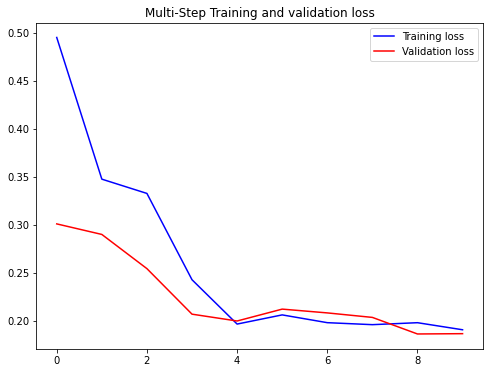

In [49]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

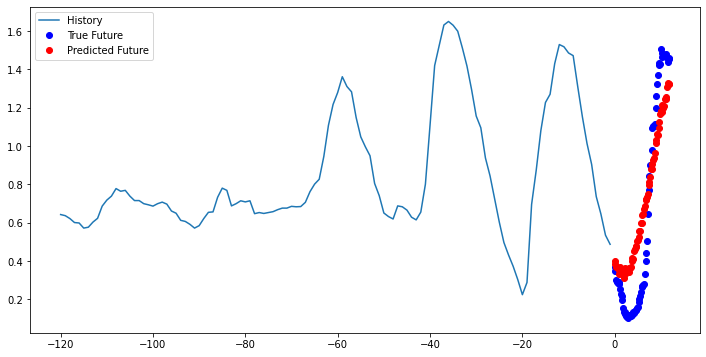

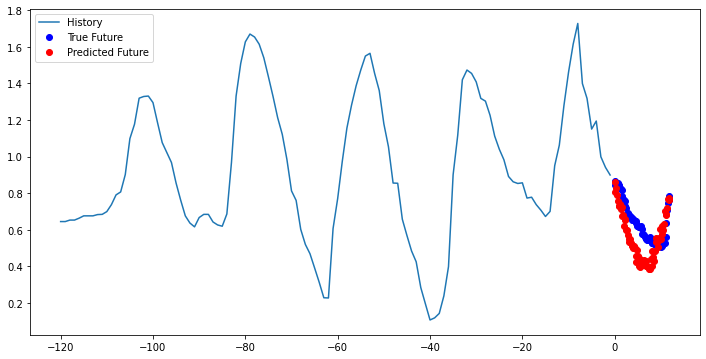

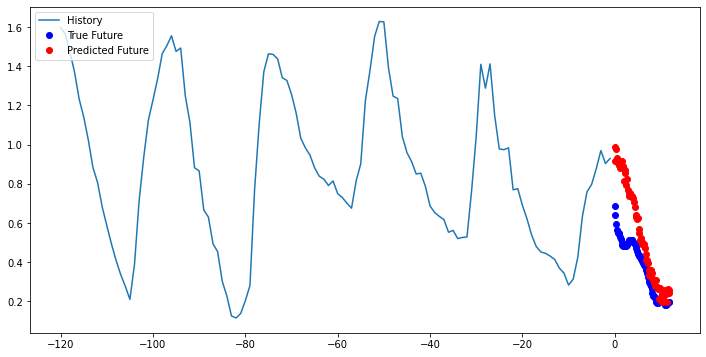

In [50]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).